In [1]:
import json
import matplotlib.pyplot as plt
import operator
import os
import sys
import typing
from collections import defaultdict
from scipy import stats
import numpy as np
import pandas as pd
from pathlib import Path

from Bio import SeqIO
 

In [2]:
sys.path.append(str(Path(os.path.dirname(os.getcwd())).parent))

In [3]:
from generate_summary_file import generate_summary
from input_testing_data.generate_input_testing_data_for_modules import generate_testing_data_for_ecoli_and_bacillus
from modules.main import run_modules
from modules.main import run_input_processing
from modules.main import EvaluationModule
from modules.run_summary import RunSummary
from modules import shared_functions_and_vars
from modules import models

In [4]:
def get_user_input(optimization_method: str,
                   is_ecoli_optimized: bool,
                   orf_sequence: typing.Optional[str] = None,
                   orf_sequence_file: typing.Optional[str] = None,
                   output_path: typing.Optional[str] = None,
                   optimization_cub_index: str = "CAI",
                   tuning_param: float = 0.5,
                   should_use_mrna_levels = True,
                   should_use_protein_abundance = False):
    default_user_inp_raw = generate_testing_data_for_ecoli_and_bacillus(
        optimization_method=optimization_method,
        optimization_cub_index=optimization_cub_index,
        clusters_count=1,
        tuning_param=tuning_param,
        is_ecoli_optimized=is_ecoli_optimized,
        sequence=orf_sequence,
        sequence_file_path=orf_sequence_file,
        output_path=os.path.join("results", output_path),
        should_use_mrna_levels=should_use_mrna_levels,
        should_use_protein_abundance=should_use_protein_abundance,
    )
    return run_input_processing(default_user_inp_raw) 

In [5]:
def evaluate_score_for_sequence(sequence: str,
                                user_input: models.UserInput,
                                optimization_method: str,
                                is_ecoli_optimized: bool,
                                orf_sequence: typing.Optional[str] = None,
                                orf_sequence_file: typing.Optional[str] = None,
                                output_path: typing.Optional[str] = None,
                                optimization_cub_index: str = "CAI",
                                tuning_param: float = 0.5,
                                should_use_mrna_levels = True,
                                should_use_protein_abundance = False):
    run_summary = RunSummary()
    return EvaluationModule.run_module(final_sequence=sequence, 
                                       user_input=user_input,
                                       optimization_cub_index=user_input.optimization_cub_index,
                                       run_summary=run_summary)

In [6]:
def run_single_method_for_orf_sequence(optimization_method: str,
                                       is_ecoli_optimized: bool,
                                       orf_sequence: typing.Optional[str] = None,
                                       orf_sequence_file: typing.Optional[str] = None,
                                       output_path: typing.Optional[str] = None,
                                       optimization_cub_index: str = "CAI",
                                       tuning_param: float = 0.5,
                                       should_use_mrna_levels = True,
                                       should_use_protein_abundance = False):
    default_user_inp_raw = generate_testing_data_for_ecoli_and_bacillus(
        optimization_method=optimization_method,
        optimization_cub_index=optimization_cub_index,
        clusters_count=1,
        tuning_param=tuning_param,
        is_ecoli_optimized=is_ecoli_optimized,
        sequence=orf_sequence,
        sequence_file_path=orf_sequence_file,
        output_path=os.path.join("results", output_path),
        should_use_mrna_levels=should_use_mrna_levels,
        should_use_protein_abundance=should_use_protein_abundance,
    )
    return run_modules(default_user_inp_raw)

In [7]:
def run_all_methods(orf_sequence = None, orf_sequence_file = None, output_path = None, tuning_param: int = 0.5, should_use_mrna_levels: bool = True, should_use_protein_abundance: bool = False):
    for optimization_method in [
        "single_codon_ratio",
        "single_codon_diff",
        # "single_codon_weakest_link",
        # "zscore_single_aa_ratio",
        "zscore_bulk_aa_ratio",
        # "zscore_single_aa_diff",
        "zscore_bulk_aa_diff",
        # "zscore_single_aa_weakest_link",
        # "zscore_bulk_aa_weakest_link",
    ]:
        for optimization_cub_index in ["CAI", "tAI"]:
            for direction in [True, False]:
                run_single_method_for_orf_sequence(optimization_method=optimization_method,
                                                   optimization_cub_index=optimization_cub_index,
                                                   is_ecoli_optimized=direction,
                                                   orf_sequence=orf_sequence,
                                                   orf_sequence_file=orf_sequence_file,
                                                   output_path=output_path,
                                                   tuning_param=tuning_param,
                                                   should_use_mrna_levels=should_use_mrna_levels,
                                                   should_use_protein_abundance=should_use_protein_abundance)

In [8]:
def generate_sequences_fasta_file(root_dir) -> None:
    filename = "run_summary.json"

    sequences = []
    sequences_names = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file == filename:
                directory_name = Path(root).name
                file_path = os.path.join(root, file)
                with open(file_path, "r") as summary_file:
                    results_json = json.load(summary_file)

                seq = results_json["final_evaluation"]["final_sequence"]
                sequences.append(seq)
                sequences_names.append(directory_name[:-5])

    shared_functions_and_vars.write_fasta(os.path.join(root_dir, "mcherry_variants"), sequences, sequences_names)

In [9]:
def calculate_codon_frequencies(referece_cds: typing.Sequence[str]):
    codons_counter = defaultdict(int)
    
    for cds in referece_cds:
        if len(cds) % 3 != 0:
            continue
        for i in range(0, len(cds), 3):
            codon = cds[i:i+3]
            codons_counter[codon] += 1
    
    # Calculate relative frequncies
    for amino_acid, codons in shared_functions_and_vars.synonymous_codons.items():
        total_amino_acid_codons = 0
        for amino_acid_codon in codons:
            total_amino_acid_codons += codons_counter[amino_acid_codon]
        
        # In case a certain amino acid is missing from the reference cds collection, no need to normalize
        if total_amino_acid_codons == 0:
            continue
        
        for amino_acid_codon in codons:
            codons_counter[amino_acid_codon] /= total_amino_acid_codons
    
    codons = list(codons_counter.keys())
    df_dict = {"codon": codons, "amino_acid": [shared_functions_and_vars.nt_to_aa[codon] for codon in codons], "frequency": [codons_counter[codon] for codon in codons]}

    return pd.DataFrame(df_dict)

In [10]:
def calculate_codon_frequencies_lamda(referece_cds: typing.Sequence[str]):
    codons_counter = defaultdict(int)
    
    for cds in referece_cds:
        if len(cds) % 3 != 0:
            continue
        for i in range(0, len(cds), 3):
            codon = cds[i:i+3]
            codons_counter[codon] += 1
    
    # Calculate relative frequncies
    for amino_acid, codons in shared_functions_and_vars.synonymous_codons.items():
        amino_acid_codon_to_count = {codon: codons_counter[codon] for codon in codons}
        most_frequent_codon = max(amino_acid_codon_to_count, key=amino_acid_codon_to_count.get)
        
        if amino_acid_codon_to_count[most_frequent_codon] == 0:
            # In case a certain amino acid is missing from the reference cds collection, no need to normalize
            continue
            
        for amino_acid_codon in codons:
            codons_counter[amino_acid_codon] = 1 if amino_acid_codon == most_frequent_codon else 0 
    
    codons = list(codons_counter.keys())
    df_dict = {"codon": codons, "amino_acid": [shared_functions_and_vars.nt_to_aa[codon] for codon in codons], "frequency": [codons_counter[codon] for codon in codons]}
    
    return pd.DataFrame(df_dict)

In [11]:
def plot_frequency_map(frequency_df):
    sorted_df = frequency_df.sort_values("amino_acid")
    
    plt.rcParams["figure.figsize"] = [10, 5]
    plt.rcParams["figure.autolayout"] = True

    sorted_df.plot("codon", "frequency", kind="bar", color = "b")

In [12]:
def calculate_distance_between_frequencies(first_codons_freq, second_codons_freq):
    return np.linalg.norm(first_codons_freq-second_codons_freq)

In [13]:
def get_variants_df_dict(variants_root_path, ecoli_codon_frequencies, bacillus_codon_frequencies, ecoli_codon_frequencies_lamda, bacillus_codon_frequencies_lamda):
    with open(variants_root_path, "r") as mcherry_variants_fasta_file:
        mcherry_variants_dict = SeqIO.to_dict(SeqIO.parse(mcherry_variants_fasta_file, "fasta"))

    unified_variants_dict = defaultdict(dict)

    for variant_name, variant_seq in mcherry_variants_dict.items():  
        stripped_name = variant_name.replace("_False", "").replace("_True", "").replace("_ecoli_opt", "")
       
        mcherry_variant_codon_frequencies = calculate_codon_frequencies((str(variant_seq.seq),)).sort_values("codon")
        mcherry_variant_codon_frequencies_lamda = calculate_codon_frequencies_lamda((str(variant_seq.seq),)).sort_values("codon")

        series1 = mcherry_variant_codon_frequencies["frequency"].reset_index(drop=True)
        series2 =  ecoli_codon_frequencies["frequency"].reset_index(drop=True)
        series3 =  bacillus_codon_frequencies["frequency"].reset_index(drop=True)
        
        ecoli_dist = calculate_distance_between_frequencies(series1, series2)
        bacillus_dist = calculate_distance_between_frequencies(series1, series3)
        
        series1_lamda = mcherry_variant_codon_frequencies_lamda["frequency"].reset_index(drop=True)
        series2_lamda =  ecoli_codon_frequencies_lamda["frequency"].reset_index(drop=True)
        series3_lamda =  bacillus_codon_frequencies_lamda["frequency"].reset_index(drop=True)
        
        ecoli_dist_lamda = calculate_distance_between_frequencies(series1_lamda, series2_lamda)
        bacillus_dist_lamda = calculate_distance_between_frequencies(series1_lamda, series3_lamda)

        if variant_name.endswith("True"):
            unified_variants_dict[stripped_name]["ecoli_dist_for_optimized_ecoli"] = ecoli_dist
            unified_variants_dict[stripped_name]["bacillus_dist_for_optimized_ecoli"] = bacillus_dist
            unified_variants_dict[stripped_name]["ecoli_dist_lamda_for_optimized_ecoli"] = ecoli_dist_lamda
            unified_variants_dict[stripped_name]["bacillus_dist_lamda_for_optimized_ecoli"] = bacillus_dist_lamda
        else:
            unified_variants_dict[stripped_name]["ecoli_dist_for_optimized_bacillus"] = ecoli_dist
            unified_variants_dict[stripped_name]["bacillus_dist_for_optimized_bacillus"] = bacillus_dist
            unified_variants_dict[stripped_name]["ecoli_dist_lamda_for_optimized_bacillus"] = ecoli_dist_lamda
            unified_variants_dict[stripped_name]["bacillus_dist_lamda_for_optimized_bacillus"] = bacillus_dist_lamda

    df_dict = defaultdict(list)
    for variant_name in unified_variants_dict.keys():
        df_dict["variant"].append(variant_name)
        df_dict["ecoli_dist_for_original_mcherry"].append(original_ecoli_dist)
        df_dict["ecoli_dist_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["ecoli_dist_for_optimized_ecoli"])
        df_dict["ecoli_dist_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["ecoli_dist_for_optimized_bacillus"])
        df_dict["ecoli_dist_lamda_for_original_mcherry"].append(original_ecoli_dist_lamda)
        df_dict["ecoli_dist_lamda_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["ecoli_dist_lamda_for_optimized_ecoli"])
        df_dict["ecoli_dist_lamda_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["ecoli_dist_lamda_for_optimized_bacillus"])

        df_dict["bacillus_dist_for_original_mcherry"].append(original_bacillus_dist)
        df_dict["bacillus_dist_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["bacillus_dist_for_optimized_ecoli"])
        df_dict["bacillus_dist_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["bacillus_dist_for_optimized_bacillus"])
        df_dict["bacillus_dist_lamda_for_original_mcherry"].append(original_bacillus_dist_lamda)
        df_dict["bacillus_dist_lamda_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["bacillus_dist_lamda_for_optimized_ecoli"])
        df_dict["bacillus_dist_lamda_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["bacillus_dist_lamda_for_optimized_bacillus"])
    
    return df_dict

In [14]:
# def get_variants_df_dict_highly_expressed(variants_root_path):
#     with open(variants_root_path, "r") as mcherry_variants_fasta_file:
#         mcherry_variants_dict = SeqIO.to_dict(SeqIO.parse(mcherry_variants_fasta_file, "fasta"))

#     unified_variants_dict = defaultdict(dict)

#     for variant_name, variant_seq in mcherry_variants_dict.items():
#         stripped_name = variant_name.replace("_False", "").replace("_True", "").replace("_ecoli_opt", "")
       
#         mcherry_variant_codon_frequencies = calculate_codon_frequencies((str(variant_seq.seq),)).sort_values("codon")
#         mcherry_variant_codon_frequencies_lamda = calculate_codon_frequencies_lamda((str(variant_seq.seq),)).sort_values("codon")

#         series1 = mcherry_variant_codon_frequencies["frequency"].reset_index(drop=True)
#         series2 =  ecoli_highly_expressed_genes_codon_frequencies["frequency"].reset_index(drop=True)
#         series3 =  bacillus_highly_expressed_genes_codon_frequencies["frequency"].reset_index(drop=True)

#         ecoli_dist = calculate_distance_between_frequencies(series1, series2)
#         bacillus_dist = calculate_distance_between_frequencies(series1, series3)
        
#         series1_lamda = mcherry_variant_codon_frequencies_lamda["frequency"].reset_index(drop=True)
#         series2_lamda =  ecoli_highly_expressed_genes_codon_frequencies_lamda["frequency"].reset_index(drop=True)
#         series3_lamda =  bacillus_highly_expressed_genes_codon_frequencies_lamda["frequency"].reset_index(drop=True)

#         ecoli_dist_lamda = calculate_distance_between_frequencies(series1_lamda, series2_lamda)
#         bacillus_dist_lamda = calculate_distance_between_frequencies(series1_lamda, series3_lamda)

#         if variant_name.endswith("True"):
#             unified_variants_dict[stripped_name]["ecoli_dist_for_optimized_ecoli"] = ecoli_dist
#             unified_variants_dict[stripped_name]["bacillus_dist_for_optimized_ecoli"] = bacillus_dist
#             unified_variants_dict[stripped_name]["ecoli_dist_lamda_for_optimized_ecoli"] = ecoli_dist_lamda
#             unified_variants_dict[stripped_name]["bacillus_dist_lamda_for_optimized_ecoli"] = bacillus_dist_lamda
#         else:
#             unified_variants_dict[stripped_name]["ecoli_dist_for_optimized_bacillus"] = ecoli_dist
#             unified_variants_dict[stripped_name]["bacillus_dist_for_optimized_bacillus"] = bacillus_dist
#             unified_variants_dict[stripped_name]["ecoli_dist_lamda_for_optimized_bacillus"] = ecoli_dist_lamda
#             unified_variants_dict[stripped_name]["bacillus_dist_lamda_for_optimized_bacillus"] = bacillus_dist_lamda

#     df_dict = defaultdict(list)
#     for variant_name in unified_variants_dict.keys():
#         df_dict["variant"].append(variant_name)
#         df_dict["ecoli_dist_for_original_mcherry"].append(original_ecoli_dist)
#         df_dict["ecoli_dist_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["ecoli_dist_for_optimized_ecoli"])
#         df_dict["ecoli_dist_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["ecoli_dist_for_optimized_bacillus"])
#         df_dict["ecoli_dist_lamda_for_original_mcherry"].append(original_ecoli_dist_lamda)
#         df_dict["ecoli_dist_lamda_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["ecoli_dist_lamda_for_optimized_ecoli"])
#         df_dict["ecoli_dist_lamda_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["ecoli_dist_lamda_for_optimized_bacillus"])

#         df_dict["bacillus_dist_for_original_mcherry"].append(original_bacillus_dist)
#         df_dict["bacillus_dist_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["bacillus_dist_for_optimized_ecoli"])
#         df_dict["bacillus_dist_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["bacillus_dist_for_optimized_bacillus"])
#         df_dict["bacillus_dist_lamda_for_original_mcherry"].append(original_bacillus_dist_lamda)
#         df_dict["bacillus_dist_lamda_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["bacillus_dist_lamda_for_optimized_ecoli"])
#         df_dict["bacillus_dist_lamda_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["bacillus_dist_lamda_for_optimized_bacillus"])
    
#     return df_dict

In [15]:
def get_codon_frequencies_df_dict(variants_root_path):
    with open(variants_root_path, "r") as mcherry_variants_fasta_file:
        mcherry_variants_dict = SeqIO.to_dict(SeqIO.parse(mcherry_variants_fasta_file, "fasta"))

    unified_variants_dict = defaultdict(dict)

    for variant_name, variant_seq in mcherry_variants_dict.items():
        if "weakest_link" in variant_name:
            continue
        
        stripped_name = variant_name.replace("_False", "").replace("_True", "").replace("_ecoli_opt", "")
       
        mcherry_variant_codon_frequencies = calculate_codon_frequencies((str(variant_seq.seq),)).sort_values("codon")
        
        return mcherry_variant_codon_frequencies 
    
        series1 = mcherry_variant_codon_frequencies["frequency"].reset_index(drop=True)
        
        if variant_name.endswith("True"):
            unified_variants_dict[stripped_name]["codon_frequencies_for_optimized_ecoli"] = mcherry_variant_codon_frequencies
        else:
            unified_variants_dict[stripped_name]["codon_frequencies_for_optimized_bacillus"] = mcherry_variant_codon_frequencies

    df_dict = defaultdict(list)
    for variant_name in unified_variants_dict.keys():
        df_dict["variant"].append(variant_name)
        df_dict["codon_frequencies_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["codon_frequencies_for_optimized_ecoli"])
        df_dict["codon_frequencies_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["codon_frequencies_for_optimized_bacillus"])
    
    return df_dict

In [16]:
def get_evaluation_summary(summary: typing.Dict[str, typing.Any], evaluation_method: str = "average_distance_score") -> typing.Dict[str, typing.Any]:
    final_evaluation = summary["final_evaluation"]
    for evaluation_summary in summary["evaluation"]:
        if evaluation_summary[evaluation_method] == final_evaluation[evaluation_method]:
            return evaluation_summary
    raise RuntimeError(F"Did not find a final evaluation for: {summary}")

In [17]:
def get_cub_score_df_dict(root_dir, evaluation_method: str = "average_distance_score"):
    filename = "run_summary.json"
    
    unified_variants_dict = defaultdict(dict)
    
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file == filename:
                directory_name = Path(root).name
                file_path = os.path.join(root, file)
                with open(file_path, "r") as summary_file:
                    results_json = json.load(summary_file)
                
                is_cai = directory_name.startswith("CAI")
                evaluation_summary = get_evaluation_summary(results_json)
                organisms = evaluation_summary["organisms"]
                for organism in organisms:
                    if organism["name"] == "Bacillus subtilis":
                        if is_cai:
                            bacillus_initial_score = organism["cai_initial_score"]
                            bacillus_final_score = organism["cai_final_score"]
                        else:
                            bacillus_initial_score = organism["tai_initial_score"]
                            bacillus_final_score = organism["tai_final_score"]
                    else:
                        if is_cai:
                            ecoli_initial_score = organism["cai_initial_score"]
                            ecoli_final_score = organism["cai_final_score"]
                        else:
                            ecoli_initial_score = organism["tai_initial_score"]
                            ecoli_final_score = organism["tai_final_score"]
                            
                
                variant_name = directory_name[:-5]
                stripped_name = variant_name.replace("_False", "").replace("_True", "").replace("_ecoli_opt", "")
                
                if "weakest_link" in variant_name:
                    continue
                
                if variant_name.endswith("True"):
                    suffix = "_for_optimized_ecoli"
                else:
                    suffix = "_for_optimized_bacillus"
                
                unified_variants_dict[stripped_name]["bacillus_initial_score" + suffix] = bacillus_initial_score
                unified_variants_dict[stripped_name]["bacillus_final_score" + suffix] = bacillus_final_score
                unified_variants_dict[stripped_name]["ecoli_initial_score" + suffix] = ecoli_initial_score
                unified_variants_dict[stripped_name]["ecoli_final_score" + suffix] = ecoli_final_score
                unified_variants_dict[stripped_name]["average_distance_evaluation_score" + suffix] = evaluation_summary["average_distance_score"]
                unified_variants_dict[stripped_name]["weakest_link_evaluation_score" + suffix] = evaluation_summary["weakest_link_score"]
                unified_variants_dict[stripped_name]["ratio_evaluation_score" + suffix] = evaluation_summary["ratio_score"]
                
    
    df_dict = defaultdict(list)
    for variant_name in unified_variants_dict.keys():
        df_dict["variant"].append(variant_name)
        df_dict["ecoli_initial_score_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["ecoli_initial_score_for_optimized_ecoli"])
        df_dict["ecoli_final_score_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["ecoli_final_score_for_optimized_ecoli"])
        df_dict["ecoli_initial_score_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["ecoli_initial_score_for_optimized_bacillus"])
        df_dict["ecoli_final_score_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["ecoli_final_score_for_optimized_bacillus"])
        df_dict["bacillus_initial_score_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["bacillus_initial_score_for_optimized_ecoli"])
        df_dict["bacillus_final_score_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["bacillus_final_score_for_optimized_ecoli"])
        df_dict["bacillus_initial_score_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["bacillus_initial_score_for_optimized_bacillus"])
        df_dict["bacillus_final_score_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["bacillus_final_score_for_optimized_bacillus"])
        df_dict["average_distance_evaluation_score_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["average_distance_evaluation_score_for_optimized_ecoli"])
        df_dict["average_distance_evaluation_score_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["average_distance_evaluation_score_for_optimized_bacillus"])
        df_dict["weakest_link_evaluation_score_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["weakest_link_evaluation_score_for_optimized_ecoli"])
        df_dict["weakest_link_evaluation_score_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["weakest_link_evaluation_score_for_optimized_bacillus"])
        df_dict["ratio_evaluation_score_for_optimized_ecoli"].append(unified_variants_dict[variant_name]["ratio_evaluation_score_for_optimized_ecoli"])
        df_dict["ratio_evaluation_score_for_optimized_bacillus"].append(unified_variants_dict[variant_name]["ratio_evaluation_score_for_optimized_bacillus"])
    
    return df_dict

In [18]:
def get_cub_weights(organism_summary_file_path: str):
    with open(organism_summary_file_path, "r") as organism_summary_file:
        organism_summary = json.load(organism_summary_file)
    
    cai_profile = organism_summary["cai_weights"]
    tai_profile = organism_summary["tai_weights"]
    
    return cai_profile, tai_profile

In [19]:
def get_cub_scores(organism_summary_file_path: str):
    with open(organism_summary_file_path, "r") as organism_summary_file:
        organism_summary = json.load(organism_summary_file)
    
    cai_scores = organism_summary["cai_scores"]
    tai_scores = organism_summary["tai_scores"]
    
    return cai_scores, tai_scores

In [20]:
def get_mrna_estimated_expression(endogenous_genes_fasta_file_path, mrna_levels_file_path):
    expression_df = pd.read_csv(mrna_levels_file_path)
    gene_name_to_mrna_level = {}
    for _, pair in enumerate(zip(expression_df.gene.to_list(), expression_df.mRNA_level.to_list())):
        measured_gene_name, expression_level = pair
        try:
            gene_name_to_mrna_level[measured_gene_name.lower()] = float(expression_level)
        except:
            continue
            
    with open(endogenous_genes_fasta_file_path, "r") as endogenous_genes_fasta_file:
        endogenous_genes_dict = SeqIO.to_dict(SeqIO.parse(endogenous_genes_fasta_file, "fasta"), lambda x: x.description)
        
    estimated_expression = {description: {"cds": cds, "mrna_level": gene_name_to_mrna_level[description.split("|")[0].lower()]}  for description, cds in endogenous_genes_dict.items() if description.split("|")[0].lower() in gene_name_to_mrna_level}
    return estimated_expression

In [21]:
def get_pa_estimated_expression(endogenous_genes_fasta_file_path, pa_file_path):
    expression_df = pd.read_json(pa_file_path)
    gene_name_to_pa = {}
    for _, pair in enumerate(zip(expression_df.name.to_list(), expression_df.abundance.to_list())):
        measured_gene_name, expression_level = pair
        try:
            gene_name_to_pa[measured_gene_name.lower()] = float(expression_level)
        except:
            continue
            
    with open(endogenous_genes_fasta_file_path, "r") as endogenous_genes_fasta_file:
        endogenous_genes_dict = SeqIO.to_dict(SeqIO.parse(endogenous_genes_fasta_file, "fasta"), lambda x: x.description)
        
    estimated_expression = {description: {"cds": cds, "pa": gene_name_to_pa[description.split("|")[0].lower()]}  for description, cds in endogenous_genes_dict.items() if description.split("|")[0].lower() in gene_name_to_pa}
    return estimated_expression

In [22]:
def get_estimated_expression(endogenous_genes_fasta_file_path, expression_levels_file_path, expression_type: str):
    if expression_type == "mrna_levels":
        return get_mrna_estimated_expression(endogenous_genes_fasta_file_path, expression_levels_file_path)
    elif expression_type == "protein_abundance":
        return get_pa_estimated_expression(endogenous_genes_fasta_file_path, expression_levels_file_path)
    raise ValueError("Missing expression type support")

In [23]:
def get_highly_expressed_genes(endogenous_genes_fasta_file_path, expression_levels_file_path, expression_type):
    estimated_expression = get_estimated_expression(endogenous_genes_fasta_file_path=endogenous_genes_fasta_file_path, expression_levels_file_path=expression_levels_file_path, expression_type=expression_type)
    estimated_expression_threshold = 0.15
    
    expression_key = "mrna_level" if expression_type == "mrna_levels" else "pa"
    sorted_estimated_expression = dict(
        sorted(estimated_expression.items(), key=lambda x: x[1][expression_key], reverse=True)
    )
    highly_expressed_genes_count = round(len(sorted_estimated_expression) * estimated_expression_threshold)
    
    highly_expressed_names = list(sorted_estimated_expression.keys())[:highly_expressed_genes_count]
    highly_expressed_genes = {key: value for key, value in estimated_expression.items() if key in highly_expressed_names}
    return highly_expressed_genes

In [24]:
base_path = os.path.join(Path(os.getcwd()).parent.resolve(), "example_data")
macherry_file_path = os.path.join(base_path, "mCherry_original.fasta")

In [25]:
with open(macherry_file_path, "r") as mcherry_fasta_file:
    mcherry_dict = SeqIO.to_dict(SeqIO.parse(mcherry_fasta_file, "fasta"))

original_mcherry_seq = list(mcherry_dict.values())[0].seq

# Generating mcherry variants

### Tuning parameter = 0.5

#### Using protein abundance

In [26]:
# run_all_methods(orf_sequence_file=macherry_file_path, output_path="mcherry", should_use_protein_abundance=True, should_use_mrna_levels=False)

In [27]:
mcherry_root_dir = r"C:\projects\Igem_TAU_2021_moran\analysis\orf_model_analysis\results\mcherry"
mcherry_variants_file = os.path.join(mcherry_root_dir, "mcherry_variants.fasta")
generate_sequences_fasta_file(mcherry_root_dir)
generate_summary(results_directory=mcherry_root_dir)

### Tuning parameter = 1 (optimizing only wanted host and neglecting unwanted host)

#### Using protein abundance

In [28]:
# run_all_methods(orf_sequence_file=macherry_file_path, output_path="mcherry_greater_alpha", tuning_param=1, should_use_protein_abundance=True, should_use_mrna_levels=False)

In [29]:
mcherry_greater_alpha_root_dir = r"C:\projects\Igem_TAU_2021_moran\analysis\orf_model_analysis\results\mcherry_greater_alpha"
mcherry_greater_alpha_variants_file = os.path.join(mcherry_greater_alpha_root_dir, "mcherry_variants.fasta")
generate_sequences_fasta_file(mcherry_greater_alpha_root_dir)
generate_summary(results_directory=mcherry_greater_alpha_root_dir)

### Tuning parameter = 0 (de-optimizing uwanted host and neglecting wanted host)

#### Using protein abundance

In [30]:
# run_all_methods(orf_sequence_file=macherry_file_path, output_path="mcherry_lower_alpha", tuning_param=0, should_use_protein_abundance=True, should_use_mrna_levels=False)

In [31]:
mcherry_lower_alpha_root_dir = r"C:\projects\Igem_TAU_2021_moran\analysis\orf_model_analysis\results\mcherry_lower_alpha"
mcherry_lower_alpha_variants_file = os.path.join(mcherry_lower_alpha_root_dir, "mcherry_variants.fasta")
generate_sequences_fasta_file(mcherry_lower_alpha_root_dir)
generate_summary(results_directory=mcherry_lower_alpha_root_dir)

### Using ribosomal genes as highly expressed genes (instead of mRNA levels)

In [32]:
# run_all_methods(orf_sequence_file=macherry_file_path, output_path="ribosomal", should_use_mrna_levels=False)

In [33]:
# mcherry_ribosomal_root_dir = r"C:\projects\Igem_TAU_2021_moran\analysis\orf_model_analysis\results\mrna\ribosomal"
# mcherry_ribosomal_variants_file = os.path.join(mcherry_ribosomal_root_dir, "mcherry_variants.fasta")
# generate_sequences_fasta_file(mcherry_ribosomal_root_dir)
# generate_summary(results_directory=mcherry_ribosomal_root_dir)

# CUB and codon frequencies of Bacillus and E.coli

In [34]:
bacillus_endogenous_genes_fasta_file_path = r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\Bacillus-subtilis.fasta"
ecoli_endogenous_genes_fasta_file_path =  r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\Escherichia-coli.fasta"

In [35]:
with open(bacillus_endogenous_genes_fasta_file_path, "r") as bacillus_endogenous_genes_fasta_file:
    bacillus_endogenous_genes_dict = SeqIO.to_dict(SeqIO.parse(bacillus_endogenous_genes_fasta_file, "fasta"), lambda record: record.description)

bacillus_codon_frequencies = calculate_codon_frequencies([str(gene.seq) for gene in bacillus_endogenous_genes_dict.values()])
bacillus_codon_frequencies = bacillus_codon_frequencies.sort_values("codon")

bacillus_codon_frequencies_lamda = calculate_codon_frequencies_lamda([str(gene.seq) for gene in bacillus_endogenous_genes_dict.values()])
bacillus_codon_frequencies_lamda = bacillus_codon_frequencies_lamda.sort_values("codon")

with open(ecoli_endogenous_genes_fasta_file_path, "r") as ecoli_endogenous_genes_fasta_file:
    ecoli_endogenous_genes_dict = SeqIO.to_dict(SeqIO.parse(ecoli_endogenous_genes_fasta_file, "fasta"), lambda x: x.description)

ecoli_codon_frequencies = calculate_codon_frequencies([str(gene.seq) for gene in ecoli_endogenous_genes_dict.values()])
ecoli_codon_frequencies = ecoli_codon_frequencies.sort_values("codon")

ecoli_codon_frequencies_lamda = calculate_codon_frequencies_lamda([str(gene.seq) for gene in ecoli_endogenous_genes_dict.values()])
ecoli_codon_frequencies_lamda = ecoli_codon_frequencies_lamda.sort_values("codon")

In [36]:
bacillus_codon_frequencies

,codon,amino_acid,frequency
14,AAA,K,0.701613
8,AAC,N,0.434197
15,AAG,K,0.298387
2,AAT,N,0.565803
28,ACA,T,0.412072
...,...,...,...
63,TGT,C,0.454052
4,TTA,L,0.198495
50,TTC,F,0.315067
16,TTG,L,0.159230


In [37]:
ecoli_codon_frequencies

,codon,amino_acid,frequency
1,AAA,K,0.766755
9,AAC,N,0.551284
16,AAG,K,0.233245
20,AAT,N,0.448716
7,ACA,T,0.130174
...,...,...,...
54,TGT,C,0.443416
37,TTA,L,0.130076
17,TTC,F,0.426204
15,TTG,L,0.128090


In [38]:
ecoli_highly_expressed_genes = get_highly_expressed_genes(endogenous_genes_fasta_file_path=ecoli_endogenous_genes_fasta_file_path,
                                                          expression_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\PA_ecoli.json",
                                                          expression_type="protein_abundance")
# ecoli_highly_expressed_genes = get_highly_expressed_genes(endogenous_genes_fasta_file_path=ecoli_endogenous_genes_fasta_file_path,
#                                                           expression_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\ecoli_mrna_level.csv",
#                                                           expression_type="mrna_levels")
ecoli_highly_expressed_genes_codon_frequencies = calculate_codon_frequencies([str(gene["cds"].seq) for gene in ecoli_highly_expressed_genes.values()])
ecoli_highly_expressed_genes_codon_frequencies = ecoli_highly_expressed_genes_codon_frequencies.sort_values("codon")

ecoli_highly_expressed_genes_codon_frequencies_lamda = calculate_codon_frequencies_lamda([str(gene["cds"].seq) for gene in ecoli_highly_expressed_genes.values()])
ecoli_highly_expressed_genes_codon_frequencies_lamda = ecoli_highly_expressed_genes_codon_frequencies_lamda.sort_values("codon")

# bacillus_highly_expressed_genes = get_highly_expressed_genes(endogenous_genes_fasta_file_path=bacillus_endogenous_genes_fasta_file_path,
#                                                           expression_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\bacillus_mrna_level.csv",
#                                                             expression_type="mrna_levels")
bacillus_highly_expressed_genes = get_highly_expressed_genes(endogenous_genes_fasta_file_path=bacillus_endogenous_genes_fasta_file_path,
                                                             expression_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\PA_bacillus.json",
                                                            expression_type="protein_abundance")
bacillus_highly_expressed_genes_codon_frequencies = calculate_codon_frequencies([str(gene["cds"].seq) for gene in bacillus_highly_expressed_genes.values()])
bacillus_highly_expressed_genes_codon_frequencies = bacillus_highly_expressed_genes_codon_frequencies.sort_values("codon")

bacillus_highly_expressed_genes_codon_frequencies_lamda = calculate_codon_frequencies_lamda([str(gene["cds"].seq) for gene in bacillus_highly_expressed_genes.values()])
bacillus_highly_expressed_genes_codon_frequencies_lamda = bacillus_highly_expressed_genes_codon_frequencies_lamda.sort_values("codon")

Run only once - for generating both tai and cai weights dict:

In [39]:
from modules.user_IO.user_input import UserInputModule
from modules.run_summary import RunSummary

from generate_summary_file import generate_summary
from input_testing_data.generate_input_testing_data_for_modules import generate_testing_data_for_ecoli_and_bacillus
from modules.main import run_modules
from modules import shared_functions_and_vars

default_user_inp_raw = generate_testing_data_for_ecoli_and_bacillus(
    optimization_method="single_codon_diff",
    optimization_cub_index="max_CAI_tAI",
    clusters_count=1,
    tuning_param=0.5,
    is_ecoli_optimized=True,
    sequence=original_mcherry_seq,
    output_path="results",
    should_use_mrna_levels=False,
    should_use_protein_abundance=True,
)

UserInputModule.run_module(default_user_inp_raw, RunSummary())

##########################
# USER INPUT INFORMATION #
##########################
Open reading frame sequence for optimization is: ATGGTTTCCAAGGGCGAGGAGGATAACATGGCTATCATTAAAGAGTTCATGCGCTTCAAAGTTCACATGGAGGGTTCTGTTAACGGTCACGAGTTCGAGATCGAAGGCGAAGGCGAGGGCCGTCCGTATGAAGGCACCCAGACCGCCAAACTGAAAGTGACTAAAGGCGGCCCGCTGCCTTTTGCGTGGGACATCCTGAGCCCGCAATTTATGTACGGTTCTAAAGCGTATGTTAAACACCCAGCGGATATCCCGGACTATCTGAAGCTGTCTTTTCCGGAAGGTTTCAAGTGGGAACGCGTAATGAATTTTGAAGATGGTGGTGTCGTGACCGTCACTCAGGACTCCTCCCTGCAGGATGGCGAGTTCATCTATAAAGTTAAACTGCGTGGTACTAATTTTCCATCTGATGGCCCGGTGATGCAGAAAAAGACGATGGGTTGGGAGGCGTCTAGCGAACGCATGTATCCGGAAGATGGTGCGCTGAAAGGCGAAATTAAACAGCGCCTGAAACTGAAAGATGGCGGCCATTATGACGCTGAAGTGAAAACCACGTACAAAGCCAAGAAACCTGTGCAGCTGCCTGGCGCGTACAATGTGAATATTAAACTGGACATCACCTCTCATAATGAAGATTATACGATCGTAGAGCAATATGAGCGCGCGGAGGGTCGTCATTCTACCGGTGGCATGGATGAGCTGTACAAATAA
Organism is optimized
Information about Escherichia coli:
Extracting expression levels from: protein_abundance file.
Found 90 ribosomal proteins in input geno

UserInput(organisms=[<modules.models.Organism object at 0x20530FF0>, <modules.models.Organism object at 0x20995150>], sequence=Seq('ATGGTTTCCAAGGGCGAGGAGGATAACATGGCTATCATTAAAGAGTTCATGCGC...TAA'), output_path='results\\max_CAI_tAI_single_codon_diff_ecoli_opt_True_X2gf', tuning_parameter=0.5, clusters_count=1, optimization_method=<OptimizationMethod.single_codon_diff: 'single_codon_diff'>, optimization_cub_index=<OptimizationCubIndex.max_codon_trna_adaptation_index: 'max_CAI_tAI'>, evaluation_score=None)

In [40]:
ecoli_cai_weights, ecoli_tai_weights = get_cub_weights(r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\Escherichia-coli_True_parsed.json")
bacillus_cai_weights, bacillus_tai_weights = get_cub_weights(r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\Bacillus-subtilis_False_parsed.json")

In [41]:
codons = ecoli_cai_weights.keys()
weights_df_dict = {
    "codon": codons, 
    "amino_acid": [shared_functions_and_vars.nt_to_aa[k] for k in codons],
    "ecoli_cai_weights": [ecoli_cai_weights[k] for k in codons],
    "ecoli_tai_weights": [ecoli_tai_weights.get(k, 0) for k in codons],
    "bacillus_cai_weights": [bacillus_cai_weights[k] for k in codons],
    "bacillus_tai_weights": [bacillus_tai_weights.get(k, 0) for k in codons],
}
weights_dataframe = pd.DataFrame(weights_df_dict)
weights_dataframe.sort_values("amino_acid")
weights_dataframe

,codon,amino_acid,ecoli_cai_weights,ecoli_tai_weights,bacillus_cai_weights,bacillus_tai_weights
0,TAA,_,1.000000,0.00000,1.000000,0.000000
1,TAG,_,0.037037,0.00000,0.107399,0.000000
2,TGA,_,0.241830,0.00000,0.169451,0.000000
3,GCA,A,0.655401,0.37500,1.000000,0.833333
4,GCC,A,0.665265,0.25000,0.524969,0.166667
...,...,...,...,...,...,...
59,GTG,V,0.997106,0.20000,0.667237,0.213333
60,GTT,V,1.000000,0.14750,1.000000,0.098333
61,TGG,W,1.000000,0.12500,1.000000,0.166667
62,TAC,Y,1.000000,0.37500,0.777855,0.333333


Text(0.7, 0.9, 'r = 0.680')

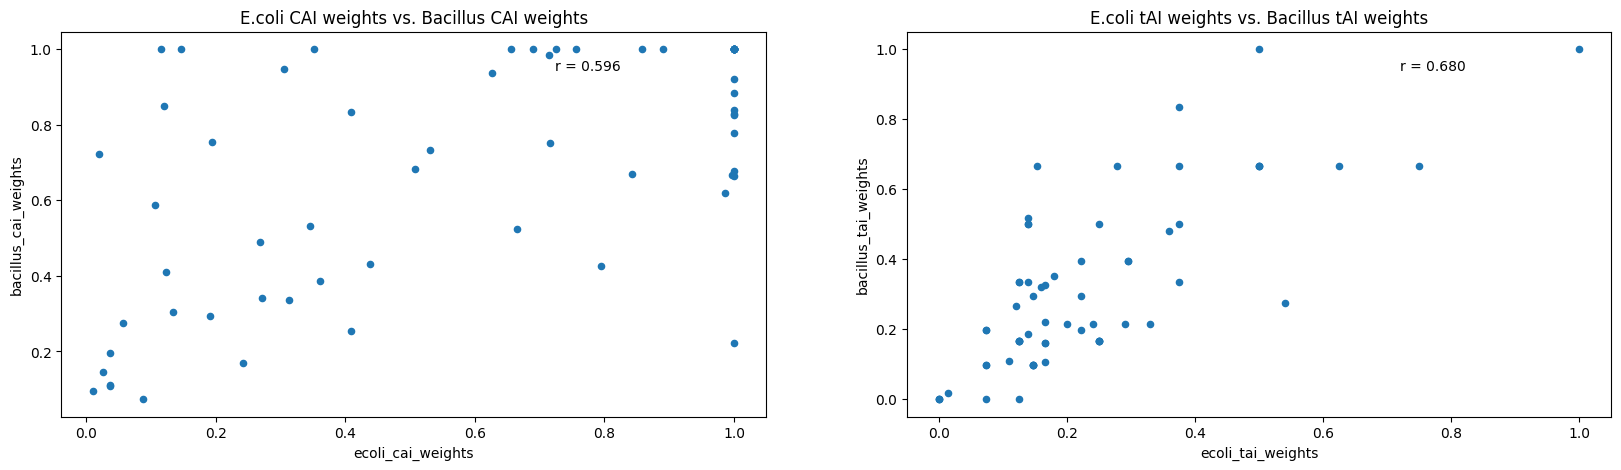

In [42]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(20,5))
scatter = weights_dataframe.plot.scatter(x="ecoli_cai_weights", y="bacillus_cai_weights", title="E.coli CAI weights vs. Bacillus CAI weights", ax=axes[0])
r, p = stats.spearmanr(weights_dataframe["ecoli_cai_weights"], weights_dataframe["bacillus_cai_weights"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = weights_dataframe.plot.scatter(x="ecoli_tai_weights", y="bacillus_tai_weights", title="E.coli tAI weights vs. Bacillus tAI weights", ax=axes[1])
r, p = stats.spearmanr(weights_dataframe["ecoli_tai_weights"], weights_dataframe["bacillus_tai_weights"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

Text(0.7, 0.9, 'r = 0.2459, p=0.05013615573693014')

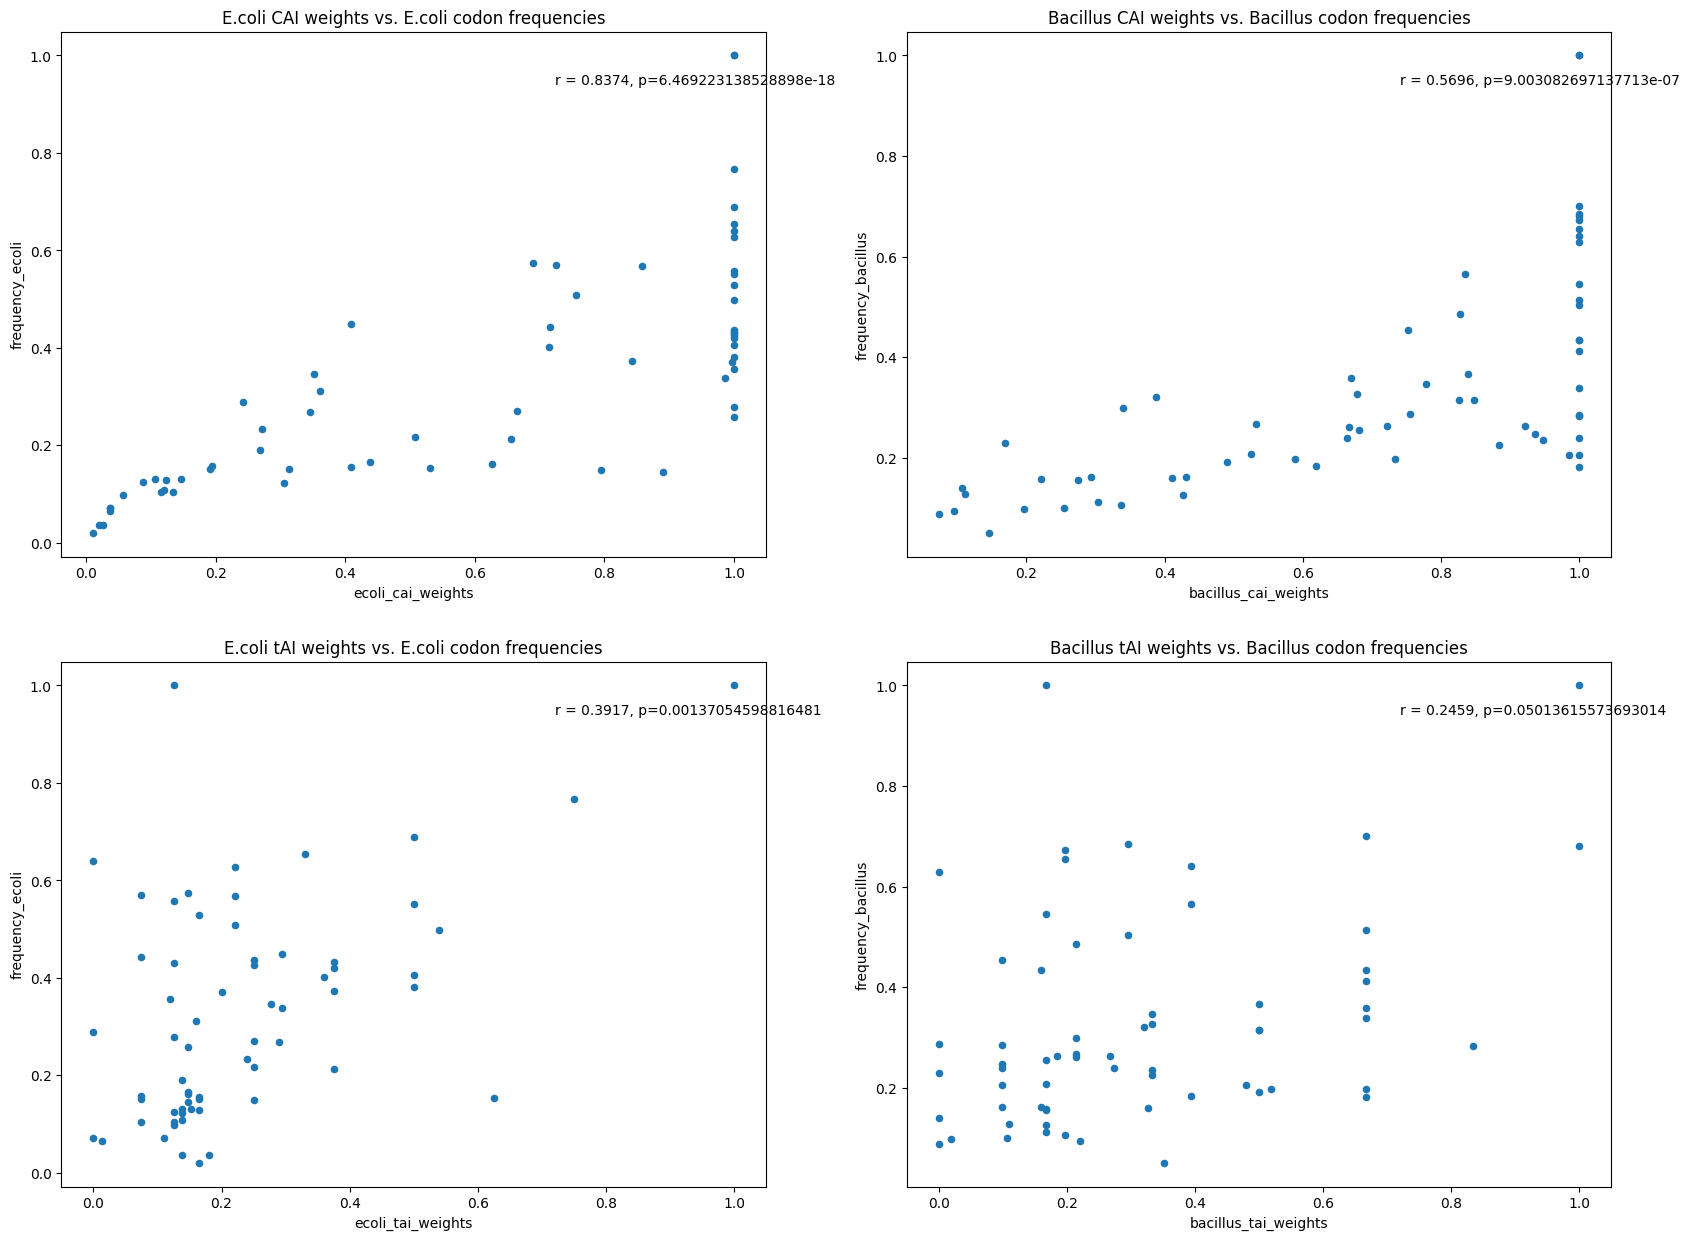

In [43]:
merged_weights_codon_frequencies_df = pd.merge(weights_dataframe, ecoli_codon_frequencies, on='codon', how='inner')
merged_weights_codon_frequencies_df = pd.merge(merged_weights_codon_frequencies_df, bacillus_codon_frequencies, on='codon', how='inner', suffixes=("_ecoli", "_bacillus"))

fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,15))
scatter = merged_weights_codon_frequencies_df.plot.scatter(x="ecoli_cai_weights", y="frequency_ecoli", title="E.coli CAI weights vs. E.coli codon frequencies", ax=axes[0,0])
r, p = stats.spearmanr(merged_weights_codon_frequencies_df["ecoli_cai_weights"], merged_weights_codon_frequencies_df["frequency_ecoli"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_weights_codon_frequencies_df.plot.scatter(x="bacillus_cai_weights", y="frequency_bacillus", title="Bacillus CAI weights vs. Bacillus codon frequencies", ax=axes[0,1])
r, p = stats.spearmanr(merged_weights_codon_frequencies_df["ecoli_cai_weights"], merged_weights_codon_frequencies_df["frequency_bacillus"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_weights_codon_frequencies_df.plot.scatter(x="ecoli_tai_weights", y="frequency_ecoli", title="E.coli tAI weights vs. E.coli codon frequencies", ax=axes[1,0])
r, p = stats.spearmanr(merged_weights_codon_frequencies_df["ecoli_tai_weights"], merged_weights_codon_frequencies_df["frequency_ecoli"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_weights_codon_frequencies_df.plot.scatter(x="bacillus_tai_weights", y="frequency_bacillus", title="Bacillus tAI weights vs. Bacillus codon frequencies", ax=axes[1,1])
r, p = stats.spearmanr(merged_weights_codon_frequencies_df["ecoli_tai_weights"], merged_weights_codon_frequencies_df["frequency_bacillus"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

Text(0.7, 0.9, 'r = 0.2721, p=0.029606945837734624')

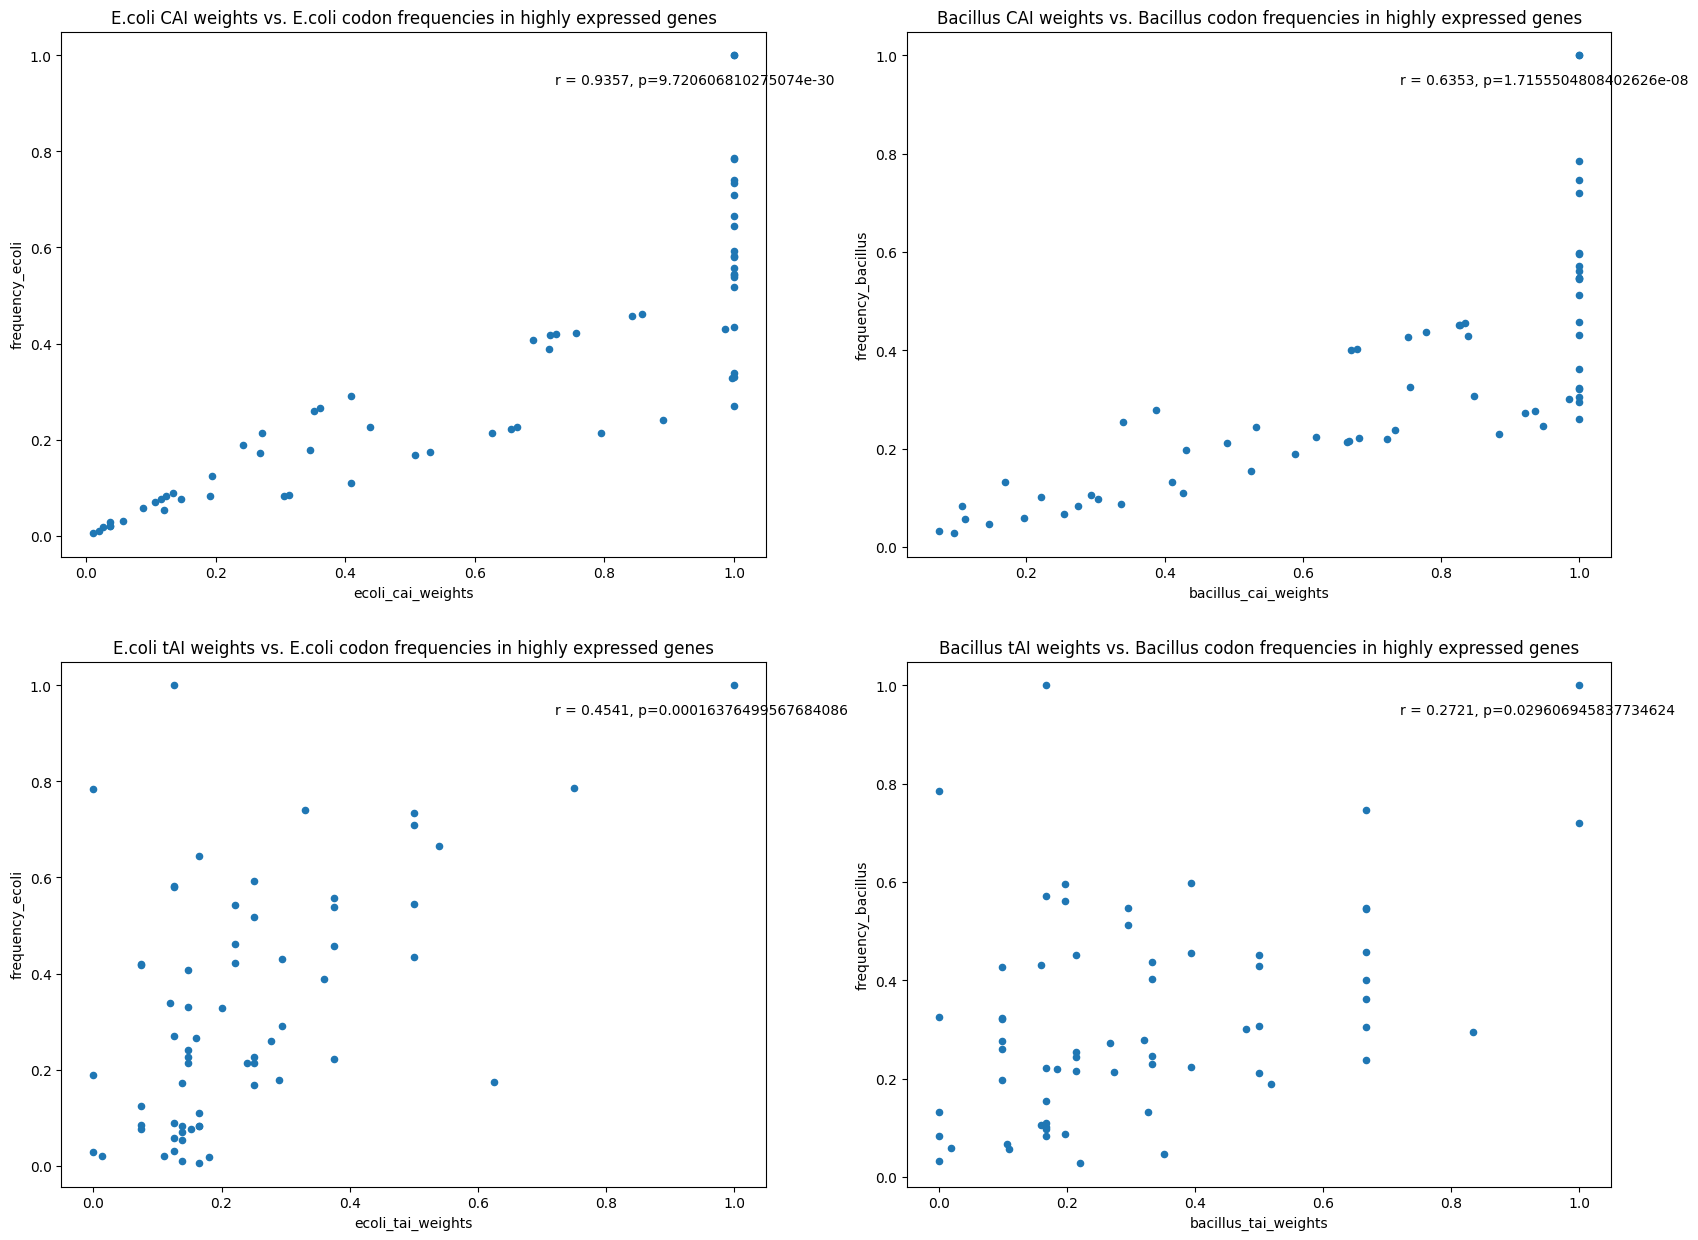

In [44]:
merged_weights_codon_frequencies_df = pd.merge(weights_dataframe, ecoli_highly_expressed_genes_codon_frequencies, on='codon', how='inner')
merged_weights_codon_frequencies_df = pd.merge(merged_weights_codon_frequencies_df, bacillus_highly_expressed_genes_codon_frequencies, on='codon', how='inner', suffixes=("_ecoli", "_bacillus"))

fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,15))
scatter = merged_weights_codon_frequencies_df.plot.scatter(x="ecoli_cai_weights", y="frequency_ecoli", title="E.coli CAI weights vs. E.coli codon frequencies in highly expressed genes", ax=axes[0,0])
r, p = stats.spearmanr(merged_weights_codon_frequencies_df["ecoli_cai_weights"], merged_weights_codon_frequencies_df["frequency_ecoli"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_weights_codon_frequencies_df.plot.scatter(x="bacillus_cai_weights", y="frequency_bacillus", title="Bacillus CAI weights vs. Bacillus codon frequencies in highly expressed genes", ax=axes[0,1])
r, p = stats.spearmanr(merged_weights_codon_frequencies_df["ecoli_cai_weights"], merged_weights_codon_frequencies_df["frequency_bacillus"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_weights_codon_frequencies_df.plot.scatter(x="ecoli_tai_weights", y="frequency_ecoli", title="E.coli tAI weights vs. E.coli codon frequencies in highly expressed genes", ax=axes[1,0])
r, p = stats.spearmanr(merged_weights_codon_frequencies_df["ecoli_tai_weights"], merged_weights_codon_frequencies_df["frequency_ecoli"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_weights_codon_frequencies_df.plot.scatter(x="bacillus_tai_weights", y="frequency_bacillus", title="Bacillus tAI weights vs. Bacillus codon frequencies in highly expressed genes", ax=axes[1,1])
r, p = stats.spearmanr(merged_weights_codon_frequencies_df["ecoli_tai_weights"], merged_weights_codon_frequencies_df["frequency_bacillus"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

In [45]:
ecoli_cai_scores, ecoli_tai_scores = get_cub_scores(r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\Escherichia-coli_True_parsed.json")
bacillus_cai_scores, bacillus_tai_scores = get_cub_scores(r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\Bacillus-subtilis_False_parsed.json")

In [46]:
def get_scores(estimated_expression_dict, cai_scores_dict, tai_scores_dict, expression_type, selected_genes=None):
    all_cds = cai_scores_dict.keys()
    selected_genes = selected_genes or all_cds
    filtered_cds = []
    expression_levels = []
    
    expression_levels_key = "mrna_level" if expression_type == "mrna_levels" else "pa"
    for k in all_cds:
        if not any(k.startswith(x) for x in selected_genes):
            continue
        short_name = k.split(" ")[0]
        # print(f"k: {k}, sort_name: {short_name}")
        for gene_name, expression in estimated_expression_dict.items():
            if gene_name.startswith(short_name):
                expression_levels.append(expression[expression_levels_key])
                filtered_cds.append(k)
                break

        
    scores_expression_levels_df_dict = {
        "gene": filtered_cds, 
        "cai_scores": [cai_scores_dict[k] for k in filtered_cds],
        "tai_scores": [tai_scores_dict[k] for k in filtered_cds],
        expression_levels_key: expression_levels,
    }
    return pd.DataFrame(scores_expression_levels_df_dict)

Ecoli mrna levels stats:
 records:3224
 min: 2.77694 
 max: 9134.66
 mean: 1078.5298904993797
 std: 1336.5741421322234
Bacillus mrna levels stats:
 records:1864
 min: 0.1 
 max: 1037.55
 mean: 19.087666309012874
 std: 64.84086443162761


<AxesSubplot:>

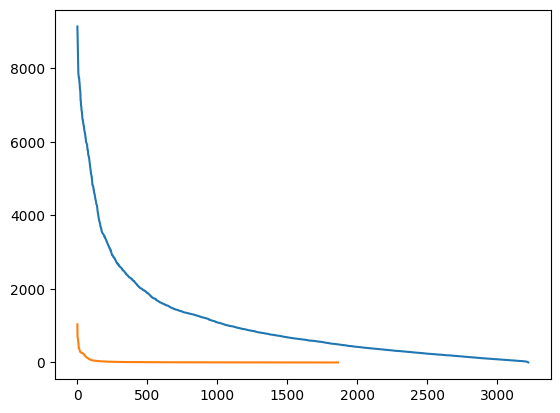

In [47]:
expression_type = "mrna_levels"
ecoli_estimated_expression = get_estimated_expression(endogenous_genes_fasta_file_path=ecoli_endogenous_genes_fasta_file_path,
                                                      expression_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\ecoli_mrna_level.csv",
                                                      expression_type=expression_type)
ecoli_scores_dataframe =  get_scores(estimated_expression_dict=ecoli_estimated_expression, cai_scores_dict=ecoli_cai_scores, tai_scores_dict=ecoli_tai_scores, expression_type=expression_type)
print(f"Ecoli mrna levels stats:\n records:{len(ecoli_scores_dataframe['mrna_level'])}\n min: {ecoli_scores_dataframe['mrna_level'].min()} \n max: {ecoli_scores_dataframe['mrna_level'].max()}\n mean: {ecoli_scores_dataframe['mrna_level'].mean()}\n std: {ecoli_scores_dataframe['mrna_level'].std()}")  
ecoli_scores_dataframe["mrna_level"].sort_values(ascending=False).reset_index(drop=True).plot()

bacillus_estimated_expression = get_estimated_expression(endogenous_genes_fasta_file_path=bacillus_endogenous_genes_fasta_file_path,
                                                         expression_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\bacillus_mrna_level.csv",
                                                          expression_type=expression_type)
bacillus_scores_dataframe =  get_scores(estimated_expression_dict=bacillus_estimated_expression, cai_scores_dict=bacillus_cai_scores, tai_scores_dict=bacillus_tai_scores, expression_type=expression_type)
print(f"Bacillus mrna levels stats:\n records:{len(bacillus_scores_dataframe['mrna_level'])}\n min: {bacillus_scores_dataframe['mrna_level'].min()} \n max: {bacillus_scores_dataframe['mrna_level'].max()}\n mean: {bacillus_scores_dataframe['mrna_level'].mean()}\n std: {bacillus_scores_dataframe['mrna_level'].std()}")  
bacillus_scores_dataframe["mrna_level"].sort_values(ascending=False).reset_index(drop=True).plot()

Text(0.7, 0.9, 'r = 0.2673, p=7.206989114855633e-32')

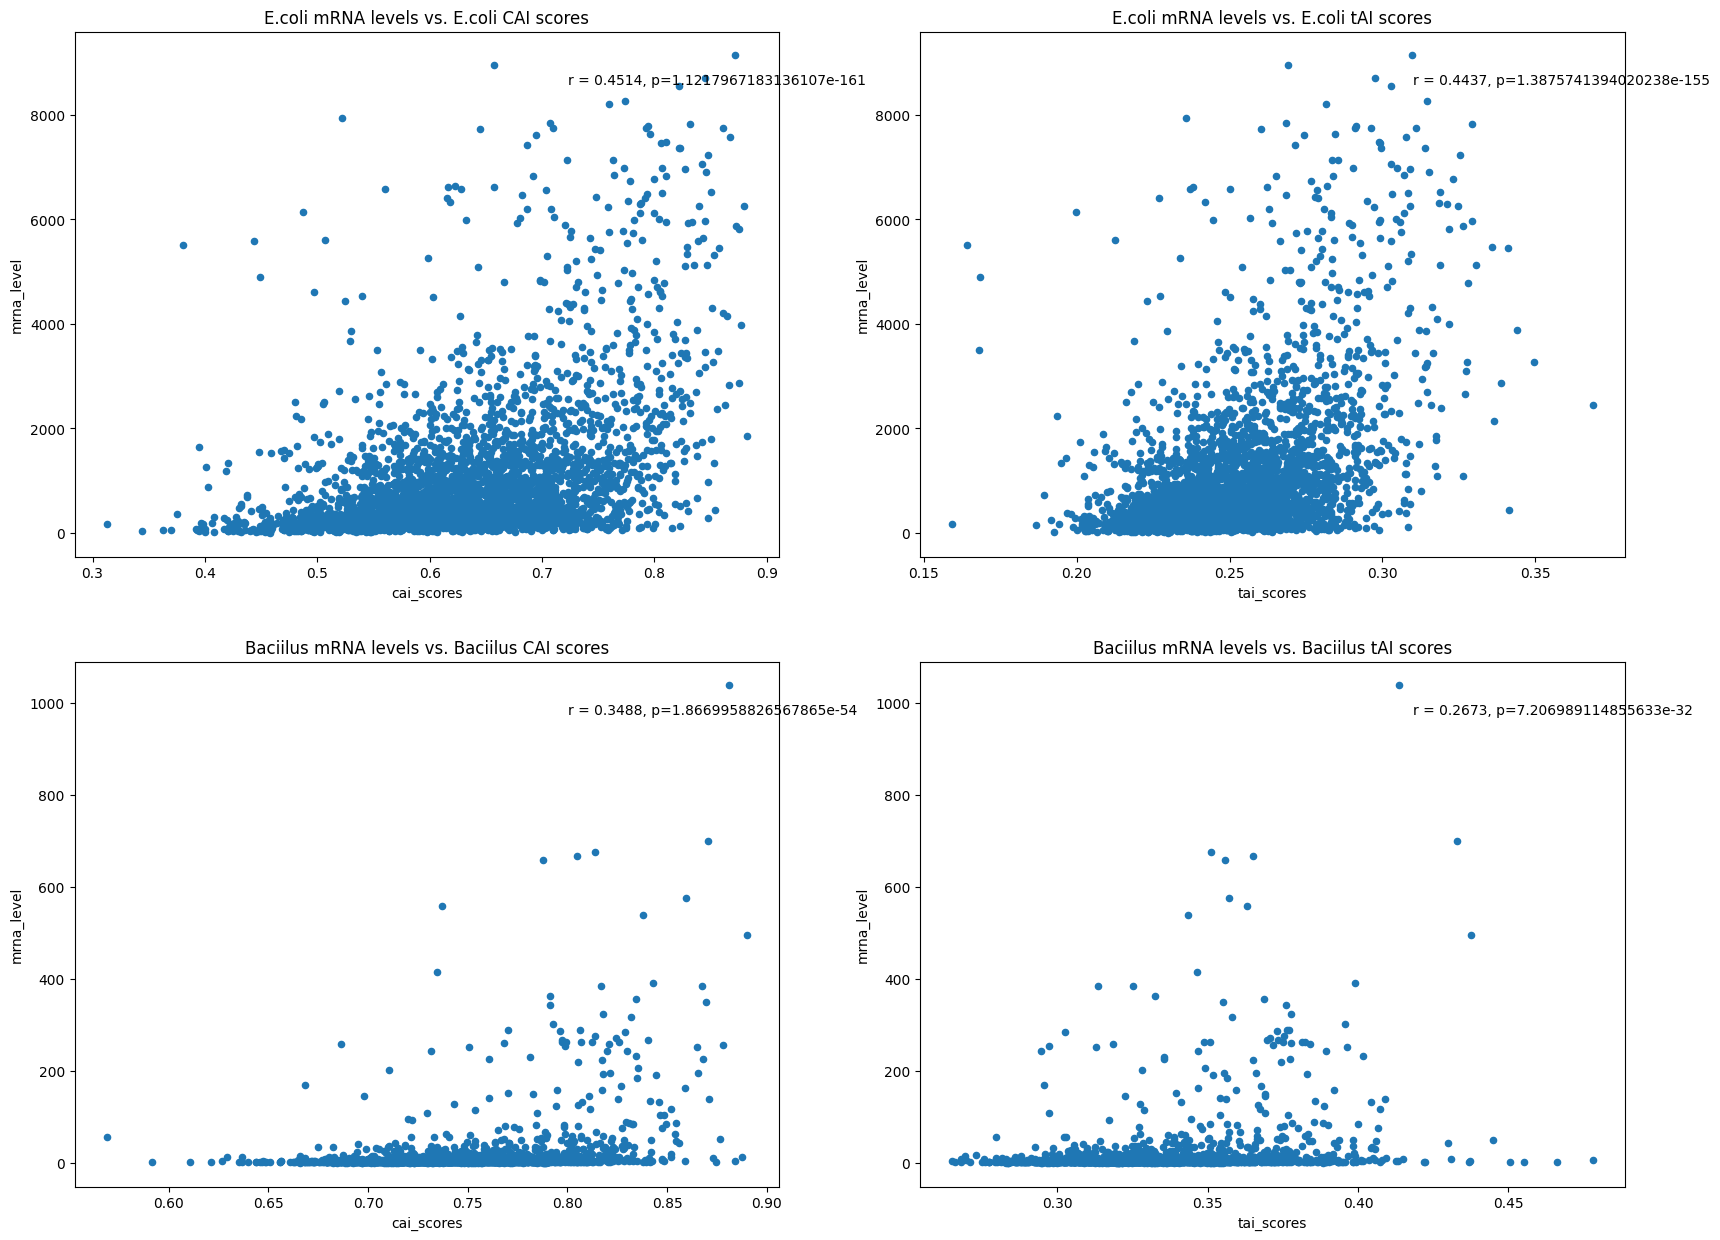

In [48]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,15))

scatter = ecoli_scores_dataframe.plot.scatter(x="cai_scores", y="mrna_level", title="E.coli mRNA levels vs. E.coli CAI scores", ax=axes[0,0])
r, p = stats.spearmanr(ecoli_scores_dataframe["cai_scores"], ecoli_scores_dataframe["mrna_level"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = ecoli_scores_dataframe.plot.scatter(x="tai_scores", y="mrna_level", title="E.coli mRNA levels vs. E.coli tAI scores", ax=axes[0,1])
r, p = stats.spearmanr(ecoli_scores_dataframe["tai_scores"], ecoli_scores_dataframe["mrna_level"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = bacillus_scores_dataframe.plot.scatter(x="cai_scores", y="mrna_level", title="Baciilus mRNA levels vs. Baciilus CAI scores", ax=axes[1,0])
r, p = stats.spearmanr(bacillus_scores_dataframe["cai_scores"], bacillus_scores_dataframe["mrna_level"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = bacillus_scores_dataframe.plot.scatter(x="tai_scores", y="mrna_level", title="Baciilus mRNA levels vs. Baciilus tAI scores", ax=axes[1,1])
r, p = stats.spearmanr(bacillus_scores_dataframe["tai_scores"], bacillus_scores_dataframe["mrna_level"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

Ecoli mrna levels stats:
 records:526
 min: 45.2732 
 max: 9134.66
 mean: 2873.7929243346007
 std: 2027.5352940754274
Bacillus mrna levels stats:
 records:419
 min: 0.3 
 max: 1037.55
 mean: 64.19424821002387
 std: 123.71735421734945


<AxesSubplot:>

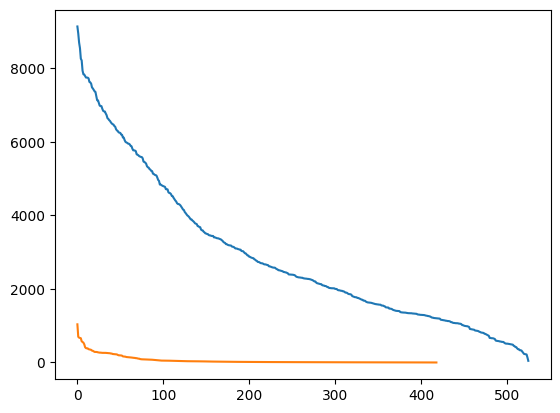

In [49]:
expression_type = "mrna_levels"
ecoli_estimated_expression = get_estimated_expression(endogenous_genes_fasta_file_path=ecoli_endogenous_genes_fasta_file_path,
                                                      expression_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\ecoli_mrna_level.csv",
                                                      expression_type=expression_type)
ecoli_highly_expressed_scores_dataframe =  get_scores(estimated_expression_dict=ecoli_estimated_expression, cai_scores_dict=ecoli_cai_scores, tai_scores_dict=ecoli_tai_scores, selected_genes=ecoli_highly_expressed_genes.keys(), expression_type=expression_type)
print(f"Ecoli mrna levels stats:\n records:{len(ecoli_highly_expressed_scores_dataframe['mrna_level'])}\n min: {ecoli_highly_expressed_scores_dataframe['mrna_level'].min()} \n max: {ecoli_highly_expressed_scores_dataframe['mrna_level'].max()}\n mean: {ecoli_highly_expressed_scores_dataframe['mrna_level'].mean()}\n std: {ecoli_highly_expressed_scores_dataframe['mrna_level'].std()}")  
ecoli_highly_expressed_scores_dataframe["mrna_level"].sort_values(ascending=False).reset_index(drop=True).plot()
bacillus_estimated_expression = get_estimated_expression(endogenous_genes_fasta_file_path=bacillus_endogenous_genes_fasta_file_path,
                                                      expression_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\bacillus_mrna_level.csv",
                                                        expression_type=expression_type)
bacillus_highly_expressed_scores_dataframe =  get_scores(estimated_expression_dict=bacillus_estimated_expression, cai_scores_dict=bacillus_cai_scores, tai_scores_dict=bacillus_tai_scores, selected_genes=bacillus_highly_expressed_genes.keys(), expression_type=expression_type)
print(f"Bacillus mrna levels stats:\n records:{len(bacillus_highly_expressed_scores_dataframe['mrna_level'])}\n min: {bacillus_highly_expressed_scores_dataframe['mrna_level'].min()} \n max: {bacillus_highly_expressed_scores_dataframe['mrna_level'].max()}\n mean: {bacillus_highly_expressed_scores_dataframe['mrna_level'].mean()}\n std: {bacillus_highly_expressed_scores_dataframe['mrna_level'].std()}")  
bacillus_highly_expressed_scores_dataframe["mrna_level"].sort_values(ascending=False).reset_index(drop=True).plot()

Text(0.7, 0.9, 'r = 0.2955, p=6.867693840115068e-10')

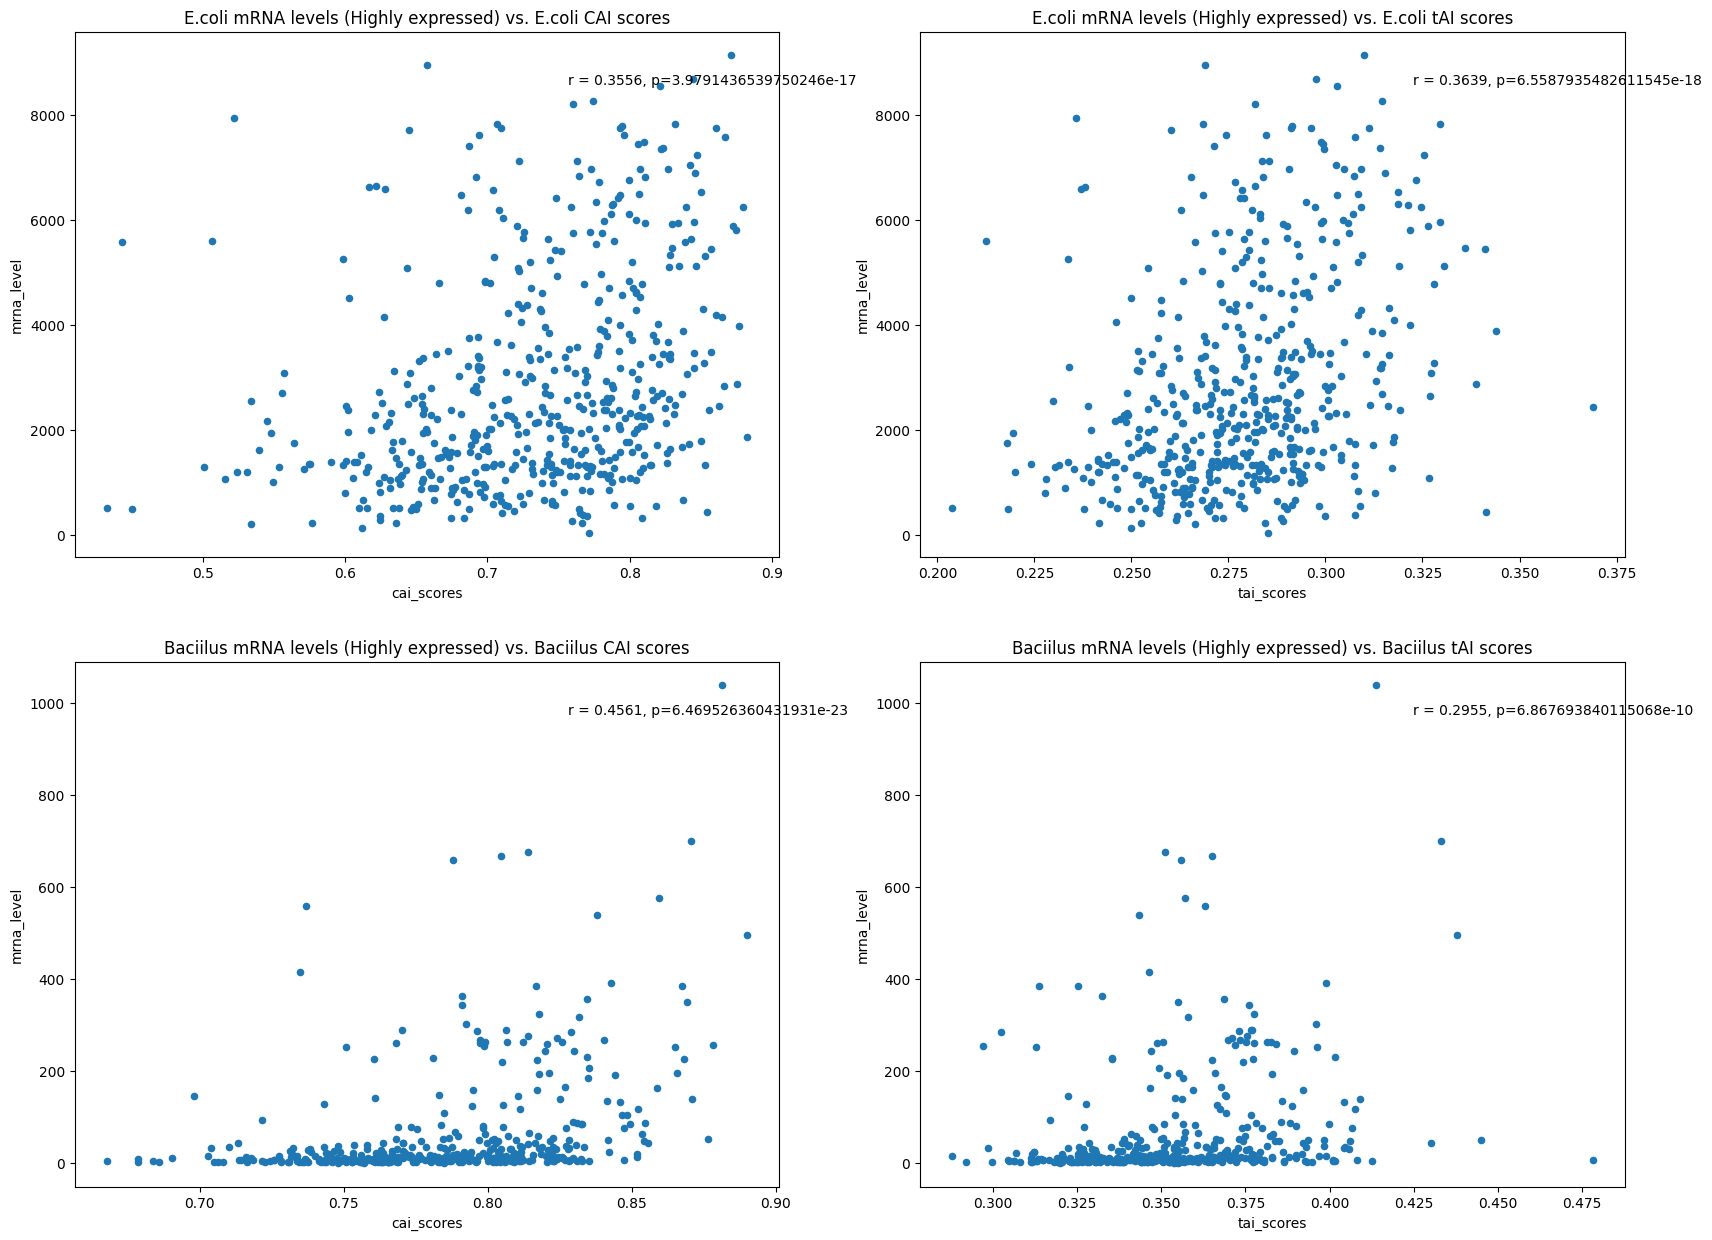

In [50]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,15))

scatter = ecoli_highly_expressed_scores_dataframe.plot.scatter(x="cai_scores", y="mrna_level", title="E.coli mRNA levels (Highly expressed) vs. E.coli CAI scores", ax=axes[0,0])
r, p = stats.spearmanr(ecoli_highly_expressed_scores_dataframe["cai_scores"], ecoli_highly_expressed_scores_dataframe["mrna_level"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = ecoli_highly_expressed_scores_dataframe.plot.scatter(x="tai_scores", y="mrna_level", title="E.coli mRNA levels (Highly expressed) vs. E.coli tAI scores", ax=axes[0,1])
r, p = stats.spearmanr(ecoli_highly_expressed_scores_dataframe["tai_scores"], ecoli_highly_expressed_scores_dataframe["mrna_level"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = bacillus_highly_expressed_scores_dataframe.plot.scatter(x="cai_scores", y="mrna_level", title="Baciilus mRNA levels (Highly expressed) vs. Baciilus CAI scores", ax=axes[1,0])
r, p = stats.spearmanr(bacillus_highly_expressed_scores_dataframe["cai_scores"], bacillus_highly_expressed_scores_dataframe["mrna_level"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = bacillus_highly_expressed_scores_dataframe.plot.scatter(x="tai_scores", y="mrna_level", title="Baciilus mRNA levels (Highly expressed) vs. Baciilus tAI scores", ax=axes[1,1])
r, p = stats.spearmanr(bacillus_highly_expressed_scores_dataframe["tai_scores"], bacillus_highly_expressed_scores_dataframe["mrna_level"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

Ecoli protein abundance stats:
 records:3893
 min: 0.0 
 max: 82534.0
 mean: 252.13351733881325
 std: 1560.6200628256245
Bacillus protein abundance stats:
 records:3544
 min: 0.092 
 max: 27351.0
 mean: 265.49945457110607
 std: 1249.1550022673223


<AxesSubplot:>

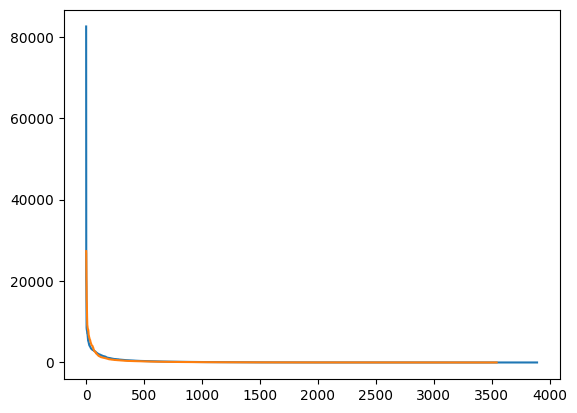

In [51]:
expression_type = "protein_abundance"
ecoli_estimated_expression_pa = get_estimated_expression(endogenous_genes_fasta_file_path=ecoli_endogenous_genes_fasta_file_path,
                                                         expression_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\PA_ecoli.json",
                                                         expression_type=expression_type)
ecoli_scores_dataframe_pa =  get_scores(estimated_expression_dict=ecoli_estimated_expression_pa, cai_scores_dict=ecoli_cai_scores, tai_scores_dict=ecoli_tai_scores, expression_type=expression_type)
print(f"Ecoli protein abundance stats:\n records:{len(ecoli_scores_dataframe_pa['pa'])}\n min: {ecoli_scores_dataframe_pa['pa'].min()} \n max: {ecoli_scores_dataframe_pa['pa'].max()}\n mean: {ecoli_scores_dataframe_pa['pa'].mean()}\n std: {ecoli_scores_dataframe_pa['pa'].std()}")  
ecoli_scores_dataframe_pa["pa"].sort_values(ascending=False).reset_index(drop=True).plot()

bacillus_estimated_expression_pa = get_estimated_expression(endogenous_genes_fasta_file_path=bacillus_endogenous_genes_fasta_file_path,
                                                         expression_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\PA_bacillus.json",
                                                          expression_type=expression_type)
bacillus_scores_dataframe_pa =  get_scores(estimated_expression_dict=bacillus_estimated_expression_pa, cai_scores_dict=bacillus_cai_scores, tai_scores_dict=bacillus_tai_scores, expression_type=expression_type)
print(f"Bacillus protein abundance stats:\n records:{len(bacillus_scores_dataframe_pa['pa'])}\n min: {bacillus_scores_dataframe_pa['pa'].min()} \n max: {bacillus_scores_dataframe_pa['pa'].max()}\n mean: {bacillus_scores_dataframe_pa['pa'].mean()}\n std: {bacillus_scores_dataframe_pa['pa'].std()}")  
bacillus_scores_dataframe_pa["pa"].sort_values(ascending=False).reset_index(drop=True).plot()

C:\projects\Igem_TAU_2021_moran\venv\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.7, 0.9, 'r = 0.4159, p=2.9135941819770878e-148')

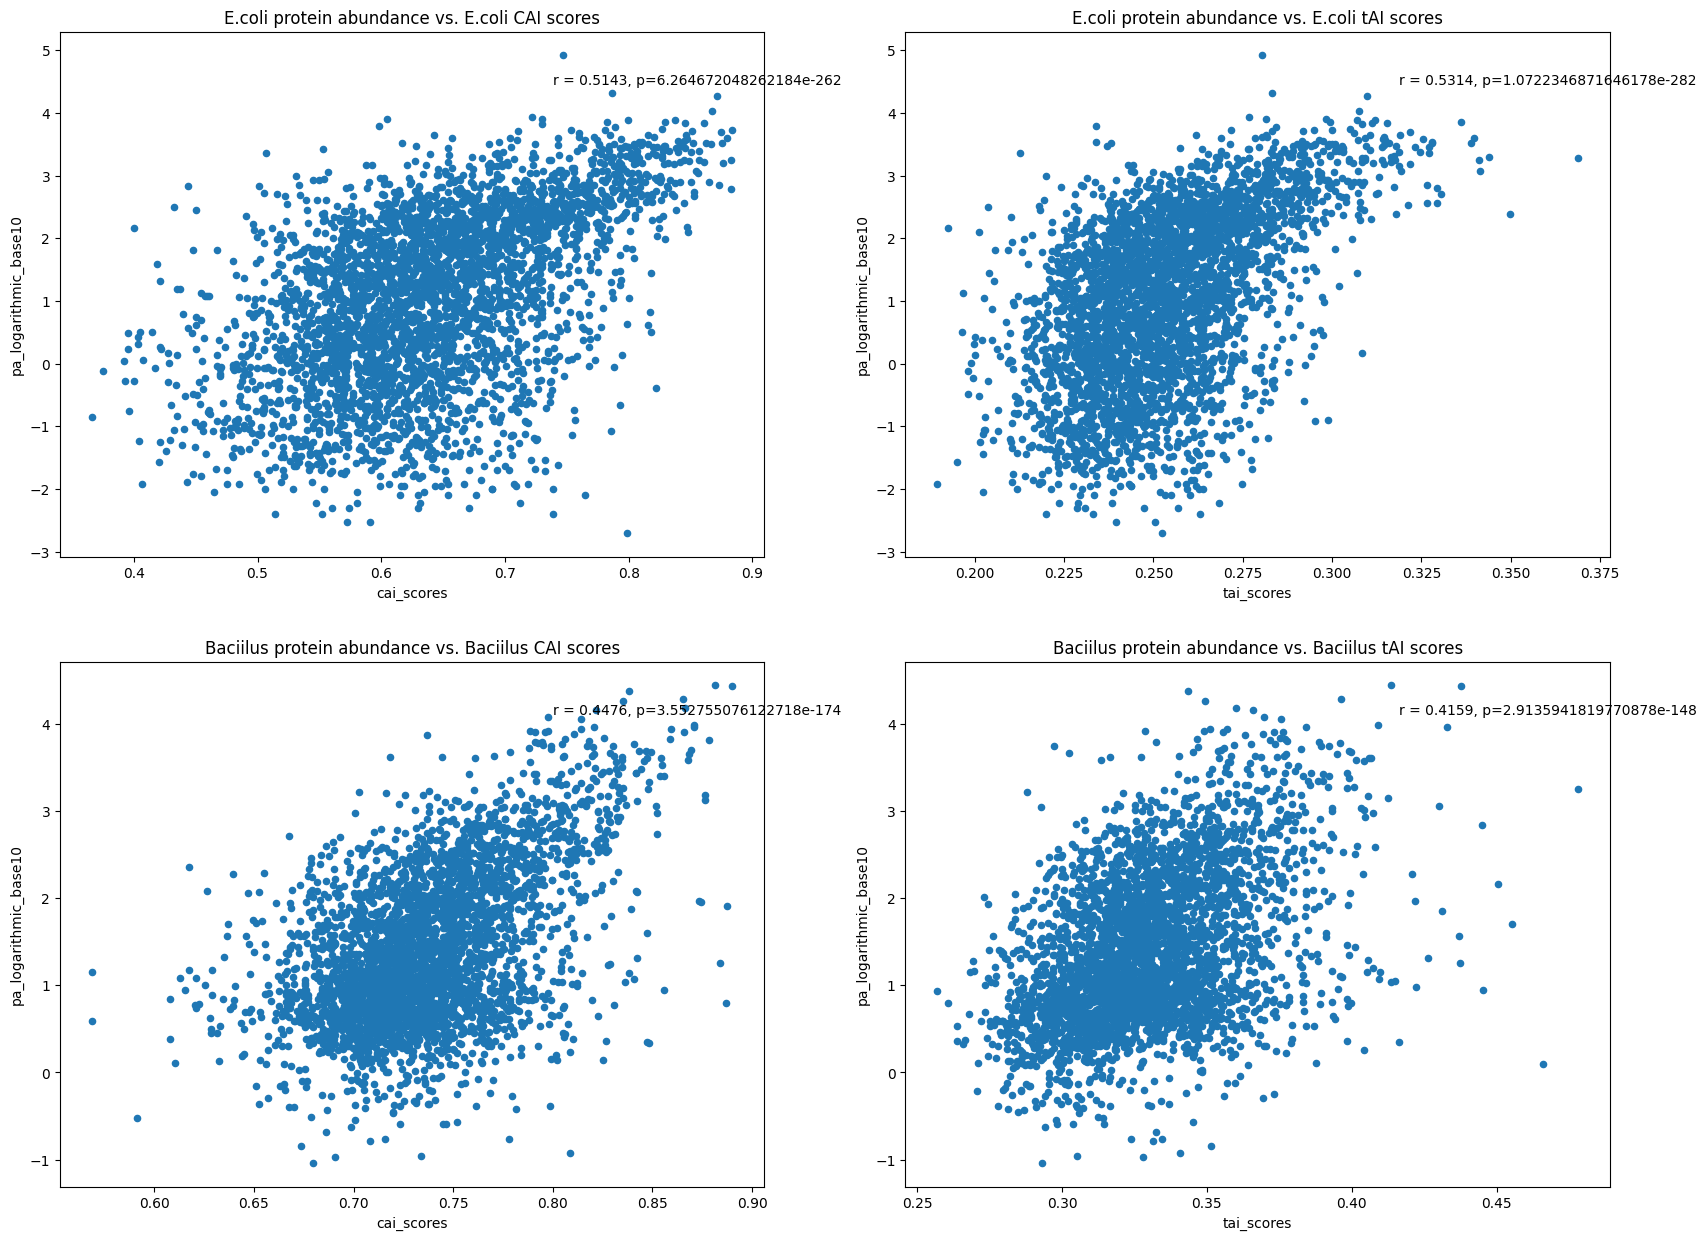

In [52]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,15))

ecoli_scores_dataframe_pa["pa_logarithmic_base10"] = np.log10(ecoli_scores_dataframe_pa['pa'])
bacillus_scores_dataframe_pa["pa_logarithmic_base10"] = np.log10(bacillus_scores_dataframe_pa['pa'])
                                                              

scatter = ecoli_scores_dataframe_pa.plot.scatter(x="cai_scores", y="pa_logarithmic_base10", title="E.coli protein abundance vs. E.coli CAI scores", ax=axes[0,0])
r, p = stats.spearmanr(ecoli_scores_dataframe_pa["cai_scores"], ecoli_scores_dataframe_pa["pa"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = ecoli_scores_dataframe_pa.plot.scatter(x="tai_scores", y="pa_logarithmic_base10", title="E.coli protein abundance vs. E.coli tAI scores", ax=axes[0,1])
r, p = stats.spearmanr(ecoli_scores_dataframe_pa["tai_scores"], ecoli_scores_dataframe_pa["pa"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = bacillus_scores_dataframe_pa.plot.scatter(x="cai_scores", y="pa_logarithmic_base10", title="Baciilus protein abundance vs. Baciilus CAI scores", ax=axes[1,0])
r, p = stats.spearmanr(bacillus_scores_dataframe_pa["cai_scores"], bacillus_scores_dataframe_pa["pa"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = bacillus_scores_dataframe_pa.plot.scatter(x="tai_scores", y="pa_logarithmic_base10", title="Baciilus protein abundance vs. Baciilus tAI scores", ax=axes[1,1])
r, p = stats.spearmanr(bacillus_scores_dataframe_pa["tai_scores"], bacillus_scores_dataframe_pa["pa"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

Ecoli protein abundance stats:
 records:584
 min: 283.0 
 max: 82534.0
 mean: 1481.859589041096
 std: 3801.991563626982
Bacillus protein abundance stats:
 records:531
 min: 250.0 
 max: 27351.0
 mean: 1562.949152542373
 std: 2903.748471885211


<AxesSubplot:>

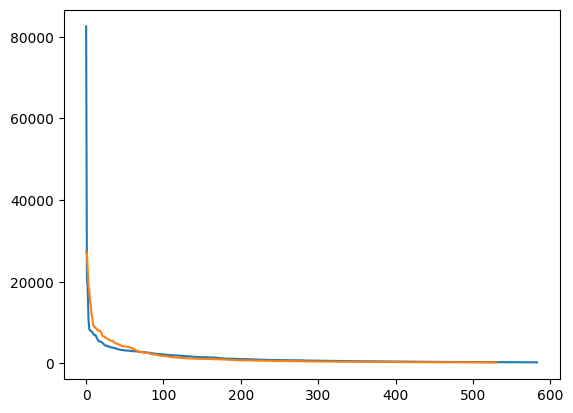

In [53]:
expression_type = "protein_abundance"
ecoli_estimated_expression_pa = get_estimated_expression(endogenous_genes_fasta_file_path=ecoli_endogenous_genes_fasta_file_path,
                                                         expression_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\PA_ecoli.json",
                                                         expression_type=expression_type)
ecoli_scores_dataframe_pa_highly_expressed =  get_scores(estimated_expression_dict=ecoli_estimated_expression_pa, cai_scores_dict=ecoli_cai_scores, tai_scores_dict=ecoli_tai_scores, expression_type=expression_type, selected_genes=ecoli_highly_expressed_genes.keys())
print(f"Ecoli protein abundance stats:\n records:{len(ecoli_scores_dataframe_pa_highly_expressed['pa'])}\n min: {ecoli_scores_dataframe_pa_highly_expressed['pa'].min()} \n max: {ecoli_scores_dataframe_pa_highly_expressed['pa'].max()}\n mean: {ecoli_scores_dataframe_pa_highly_expressed['pa'].mean()}\n std: {ecoli_scores_dataframe_pa_highly_expressed['pa'].std()}")  
ecoli_scores_dataframe_pa_highly_expressed["pa"].sort_values(ascending=False).reset_index(drop=True).plot()

bacillus_estimated_expression_pa = get_estimated_expression(endogenous_genes_fasta_file_path=bacillus_endogenous_genes_fasta_file_path,
                                                         expression_levels_file_path=r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\PA_bacillus.json",
                                                          expression_type=expression_type)
bacillus_scores_dataframe_pa_highly_expressed =  get_scores(estimated_expression_dict=bacillus_estimated_expression_pa, cai_scores_dict=bacillus_cai_scores, tai_scores_dict=bacillus_tai_scores, expression_type=expression_type, selected_genes=bacillus_highly_expressed_genes.keys())
print(f"Bacillus protein abundance stats:\n records:{len(bacillus_scores_dataframe_pa_highly_expressed['pa'])}\n min: {bacillus_scores_dataframe_pa_highly_expressed['pa'].min()} \n max: {bacillus_scores_dataframe_pa_highly_expressed['pa'].max()}\n mean: {bacillus_scores_dataframe_pa_highly_expressed['pa'].mean()}\n std: {bacillus_scores_dataframe_pa_highly_expressed['pa'].std()}")  
bacillus_scores_dataframe_pa_highly_expressed["pa"].sort_values(ascending=False).reset_index(drop=True).plot()

Text(0.7, 0.9, 'r = 0.3794, p=1.2786680615726634e-19')

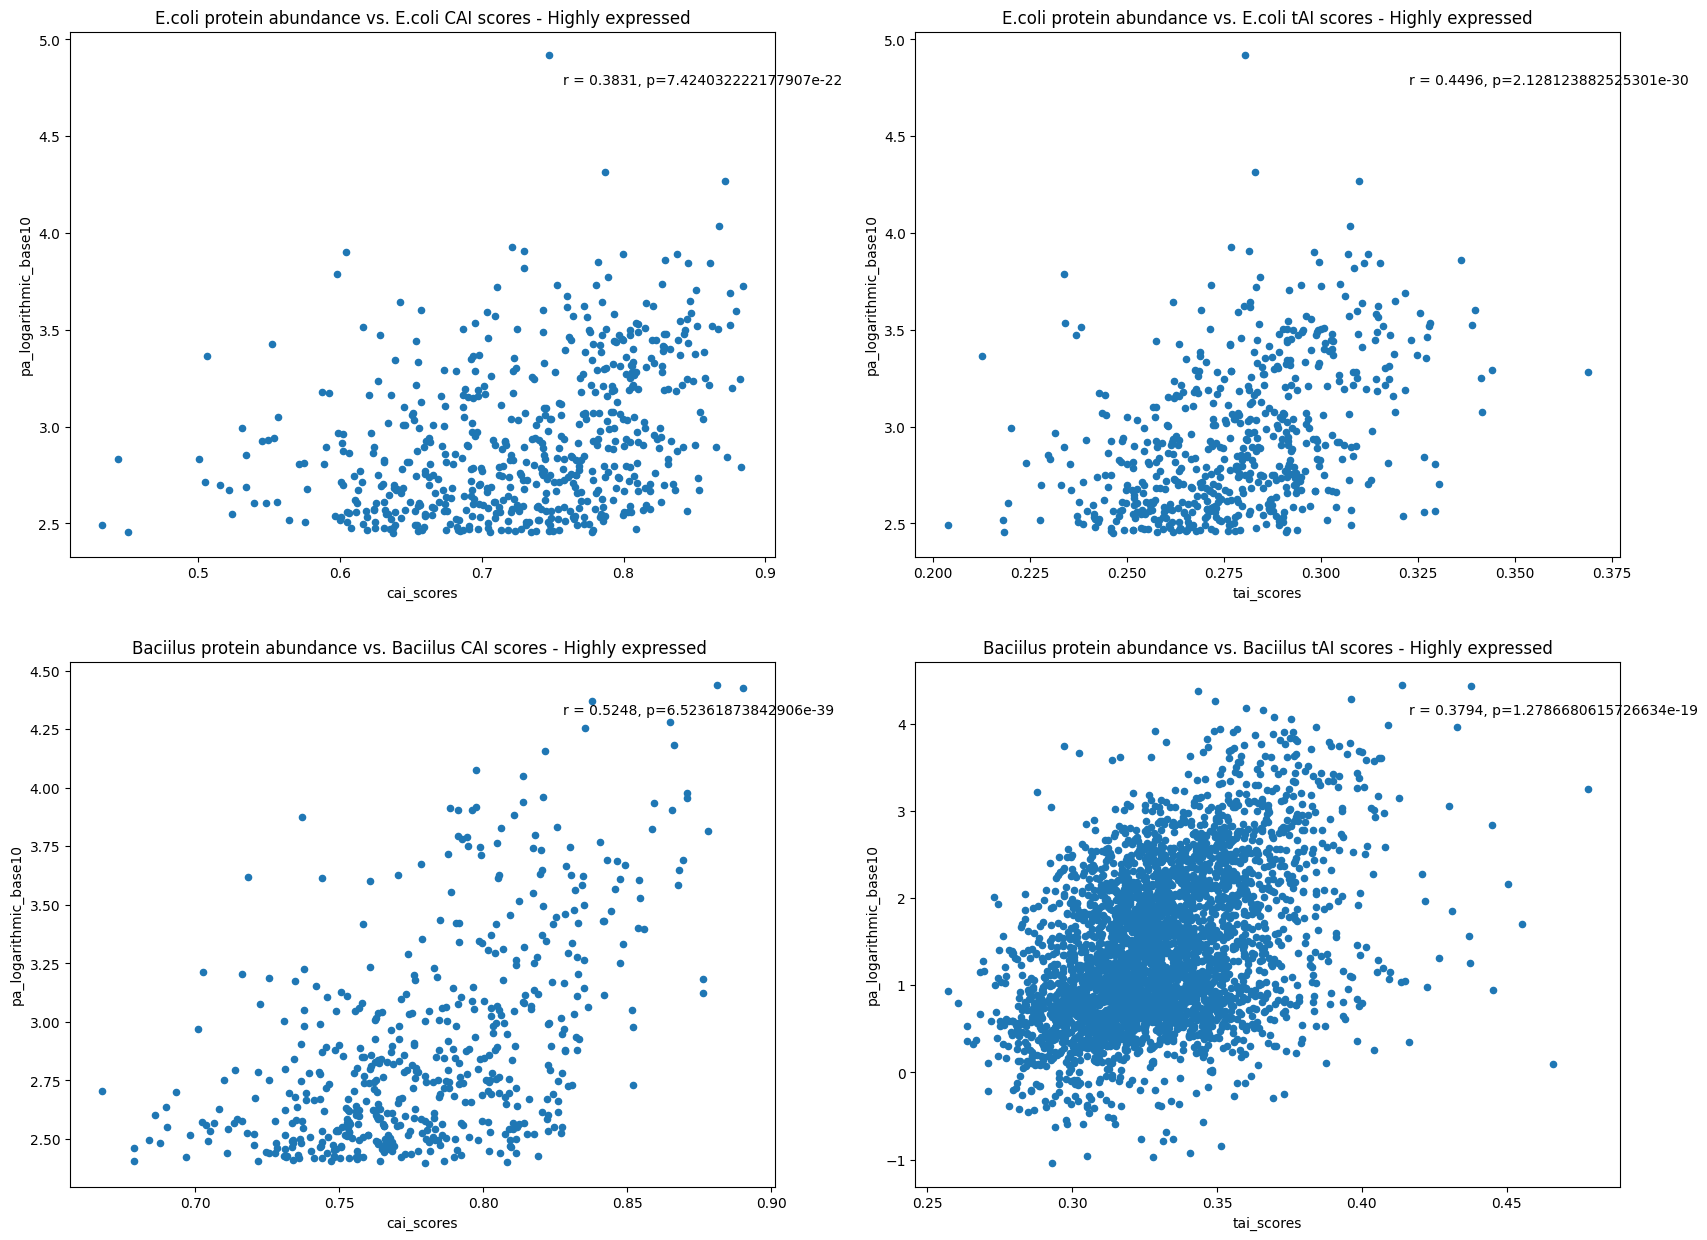

In [54]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,15))

ecoli_scores_dataframe_pa_highly_expressed["pa_logarithmic_base10"] = np.log10(ecoli_scores_dataframe_pa_highly_expressed['pa'])
bacillus_scores_dataframe_pa_highly_expressed["pa_logarithmic_base10"] = np.log10(bacillus_scores_dataframe_pa_highly_expressed['pa'])

scatter = ecoli_scores_dataframe_pa_highly_expressed.plot.scatter(x="cai_scores", y="pa_logarithmic_base10", title="E.coli protein abundance vs. E.coli CAI scores - Highly expressed", ax=axes[0,0])
r, p = stats.spearmanr(ecoli_scores_dataframe_pa_highly_expressed["cai_scores"], ecoli_scores_dataframe_pa_highly_expressed["pa"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = ecoli_scores_dataframe_pa_highly_expressed.plot.scatter(x="tai_scores", y="pa_logarithmic_base10", title="E.coli protein abundance vs. E.coli tAI scores - Highly expressed", ax=axes[0,1])
r, p = stats.spearmanr(ecoli_scores_dataframe_pa_highly_expressed["tai_scores"], ecoli_scores_dataframe_pa_highly_expressed["pa"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = bacillus_scores_dataframe_pa_highly_expressed.plot.scatter(x="cai_scores", y="pa_logarithmic_base10", title="Baciilus protein abundance vs. Baciilus CAI scores - Highly expressed ", ax=axes[1,0])
r, p = stats.spearmanr(bacillus_scores_dataframe_pa_highly_expressed["cai_scores"], bacillus_scores_dataframe_pa_highly_expressed["pa"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = bacillus_scores_dataframe_pa.plot.scatter(x="tai_scores", y="pa_logarithmic_base10", title="Baciilus protein abundance vs. Baciilus tAI scores - Highly expressed", ax=axes[1,1])
r, p = stats.spearmanr(bacillus_scores_dataframe_pa_highly_expressed["tai_scores"], bacillus_scores_dataframe_pa_highly_expressed["pa"])
scatter.annotate('r = {:.4f}, p={}'.format(r, p), xy=(0.7, 0.9), xycoords='axes fraction')

# Verification of variants translation to correct amino acid sequence

Validating original mcherry sequence:

In [55]:
# Reference aa sequence is taken from: https://www.addgene.org/browse/sequence_vdb/6496/
reference_mcherry_protein_seq  = "MVSKGEEDNMAIIKEFMRFKVHMEGSVNGHEFEIEGEGEGRPYEGTQTAKLKVTKGGPLPFAWDILSPQFMYGSKAYVKHPADIPDYLKLSFPEGFKWERVMNFEDGGVVTVTQDSSLQDGEFIYKVKLRGTNFPSDGPVMQKKTMGWEASSERMYPEDGALKGEIKQRLKLKDGGHYDAEVKTTYKAKKPVQLPGAYNVNIKLDITSHNEDYTIVEQYERAEGRHSTGGMDELYK*"
formatted_reference_mcherry_protein_seq = reference_mcherry_protein_seq.replace("*", "_")

translated_original_mcherry_seq = shared_functions_and_vars.translate(original_mcherry_seq)

assert translated_original_mcherry_seq == formatted_reference_mcherry_protein_seq

Validating generated mcherry variants:

In [56]:
with open(mcherry_variants_file, "r") as mcherry_variants_fasta_file:
    mcherry_variants_dict = SeqIO.to_dict(SeqIO.parse(mcherry_variants_fasta_file, "fasta"))

for variant_name, variant_seq in mcherry_variants_dict.items():
    translated_seq = shared_functions_and_vars.translate(variant_seq.seq)
    if translated_seq != formatted_reference_mcherry_protein_seq:
        raise ValueError(f"Variant {variant_name} is not coding to correct sequence. \nReference sequence: {formatted_reference_mcherry_protein_seq} \nVariant sequence: {translated_seq}")

# Measurements for assessing variants scores 

#### Eucledean distance of codon frequencies

In [57]:
original_mcherry_codon_frequencies = calculate_codon_frequencies((str(original_mcherry_seq),))
original_mcherry_codon_frequencies = original_mcherry_codon_frequencies.sort_values("codon")

original_mcherry_codon_frequencies_lamda = calculate_codon_frequencies_lamda((str(original_mcherry_seq),))
original_mcherry_codon_frequencies_lamda = original_mcherry_codon_frequencies_lamda.sort_values("codon")

In [58]:
original_bacillus_dist = calculate_distance_between_frequencies(original_mcherry_codon_frequencies["frequency"].reset_index(drop=True), bacillus_codon_frequencies["frequency"].reset_index(drop=True))
original_ecoli_dist = calculate_distance_between_frequencies(original_mcherry_codon_frequencies["frequency"].reset_index(drop=True), ecoli_codon_frequencies["frequency"].reset_index(drop=True))

original_bacillus_dist_lamda = calculate_distance_between_frequencies(original_mcherry_codon_frequencies_lamda["frequency"].reset_index(drop=True), bacillus_codon_frequencies_lamda["frequency"].reset_index(drop=True))
original_ecoli_dist_lamda = calculate_distance_between_frequencies(original_mcherry_codon_frequencies_lamda["frequency"].reset_index(drop=True), ecoli_codon_frequencies_lamda["frequency"].reset_index(drop=True))

original_bacillus_dist_highly_expressed = calculate_distance_between_frequencies(original_mcherry_codon_frequencies["frequency"].reset_index(drop=True), bacillus_highly_expressed_genes_codon_frequencies["frequency"].reset_index(drop=True))
original_ecoli_dist_highly_expressed = calculate_distance_between_frequencies(original_mcherry_codon_frequencies["frequency"].reset_index(drop=True), ecoli_highly_expressed_genes_codon_frequencies["frequency"].reset_index(drop=True))

original_bacillus_dist_highly_expressed_lamda = calculate_distance_between_frequencies(original_mcherry_codon_frequencies_lamda["frequency"].reset_index(drop=True), bacillus_highly_expressed_genes_codon_frequencies_lamda["frequency"].reset_index(drop=True))
original_ecoli_dist_highly_expressed_lamda = calculate_distance_between_frequencies(original_mcherry_codon_frequencies_lamda["frequency"].reset_index(drop=True), ecoli_highly_expressed_genes_codon_frequencies_lamda["frequency"].reset_index(drop=True))

In [59]:
df_dict = get_variants_df_dict(mcherry_variants_file, ecoli_codon_frequencies, bacillus_codon_frequencies, ecoli_codon_frequencies_lamda, bacillus_codon_frequencies_lamda)

ecoli_opt_df_dict = {key: value for key, value in df_dict.items() if not key.endswith("for_optimized_bacillus")}
ecoli_opt_variants_dataframe = pd.DataFrame(ecoli_opt_df_dict)

bacillus_opt_df_dict = {key: value for key, value in df_dict.items() if not key.endswith("for_optimized_ecoli")}
bacillus_opt_variants_dataframe = pd.DataFrame(bacillus_opt_df_dict)

df_dict_highly_expressed = get_variants_df_dict(mcherry_variants_file, ecoli_highly_expressed_genes_codon_frequencies, bacillus_highly_expressed_genes_codon_frequencies, ecoli_highly_expressed_genes_codon_frequencies_lamda, bacillus_highly_expressed_genes_codon_frequencies_lamda)

ecoli_opt_df_dict_highly_expressed = {key: value for key, value in df_dict_highly_expressed.items() if not key.endswith("for_optimized_bacillus")}
ecoli_opt_variants_dataframe_highly_expressed = pd.DataFrame(ecoli_opt_df_dict_highly_expressed)

bacillus_opt_df_dict_highly_expressed = {key: value for key, value in df_dict_highly_expressed.items() if not key.endswith("for_optimized_ecoli")}
bacillus_opt_variants_dataframe_highly_expressed = pd.DataFrame(bacillus_opt_df_dict_highly_expressed)

In [60]:
bacillus_A = bacillus_codon_frequencies[bacillus_codon_frequencies["amino_acid"] == "A"].sort_values("codon")
x = pd.DataFrame(get_codon_frequencies_df_dict(mcherry_variants_file))
x_A = x[x["amino_acid"] == "A"].sort_values("codon")
original_A = original_mcherry_codon_frequencies[original_mcherry_codon_frequencies["amino_acid"] == "A"].sort_values("codon")


original_dist = calculate_distance_between_frequencies(original_A["frequency"].reset_index(drop=True), bacillus_A["frequency"].reset_index(drop=True))
variant_dist = calculate_distance_between_frequencies(x_A["frequency"].reset_index(drop=True), bacillus_A["frequency"].reset_index(drop=True))
bacillus_A

,codon,amino_acid,frequency
36,GCA,A,0.282718
10,GCC,A,0.207194
42,GCG,A,0.262551
12,GCT,A,0.247537


In [61]:
original_A

,codon,amino_acid,frequency
51,GCA,A,0.000000
23,GCC,A,0.181818
29,GCG,A,0.636364
8,GCT,A,0.181818


In [62]:
x_A

,codon,amino_acid,frequency
40,GCA,A,0.0
41,GCC,A,0.0
42,GCG,A,0.0
8,GCT,A,1.0


In [63]:
print(f"original seq dist: {original_dist}, variant dist: {variant_dist}")

original seq dist: 0.4739491539919628, variant dist: 0.8706275589823612


#### CUB scores

In [75]:
df_dict = get_cub_score_df_dict(mcherry_root_dir)
cub_ecoli_opt_df_dict = {key.replace("_for_optimized_ecoli", ""): value for key, value in df_dict.items() if not (key.endswith("_for_optimized_bacillus") or key.startswith("evaluation_score"))}
cub_ecoli_opt_variants_dataframe = pd.DataFrame(cub_ecoli_opt_df_dict)

evaluation_ecoli_opt_df_dict = {key: value for key, value in df_dict.items() if key in ["variant", "average_distance_evaluation_score_for_optimized_ecoli", "ratio_evaluation_score_for_optimized_ecoli"]}
evaluation_ecoli_opt_variants_dataframe = pd.DataFrame(evaluation_ecoli_opt_df_dict)

cub_bacillus_opt_df_dict = {key.replace("_for_optimized_bacillus", ""): value for key, value in df_dict.items() if not (key.endswith("for_optimized_ecoli") or key.startswith("evaluation_score"))}
cub_bacillus_opt_variants_dataframe = pd.DataFrame(cub_bacillus_opt_df_dict)

evaluation_bacillus_opt_df_dict = {key: value for key, value in df_dict.items() if key in ["variant", "average_distance_evaluation_score_for_optimized_bacillus", "ratio_evaluation_score_for_optimized_bacillus"]}
evaluation_bacillus_opt_variants_dataframe = pd.DataFrame(evaluation_bacillus_opt_df_dict)

In [77]:
evaluation_ecoli_opt_variants_dataframe

,variant,average_distance_evaluation_score_for_optimized_ecoli,ratio_evaluation_score_for_optimized_ecoli
0,CAI_single_codon_diff,1.909399,1.364693
1,CAI_single_codon_ratio,1.960126,1.261553
2,CAI_zscore_bulk_aa_diff,2.463100,1.739401
3,CAI_zscore_bulk_aa_ratio,2.385041,10.215349


#### tuning parameter = 1 - Eucledean distance of codon frequencies

In [67]:
greater_alpha_df_dict = get_variants_df_dict(mcherry_greater_alpha_variants_file, ecoli_codon_frequencies, bacillus_codon_frequencies, ecoli_codon_frequencies_lamda, bacillus_codon_frequencies_lamda)
    
greater_alpha_ecoli_opt_df_dict = {key: value for key, value in greater_alpha_df_dict.items() if not key.endswith("for_optimized_bacillus")}
greater_alpha_ecoli_opt_variants_dataframe = pd.DataFrame(greater_alpha_ecoli_opt_df_dict)

greater_alpha_bacillus_opt_df_dict = {key: value for key, value in greater_alpha_df_dict.items() if not key.endswith("for_optimized_ecoli")}
greater_alpha_bacillus_opt_variants_dataframe = pd.DataFrame(greater_alpha_bacillus_opt_df_dict)

greater_alpha_df_dict_highly_expressed = get_variants_df_dict(mcherry_greater_alpha_variants_file, ecoli_highly_expressed_genes_codon_frequencies, bacillus_highly_expressed_genes_codon_frequencies, ecoli_highly_expressed_genes_codon_frequencies_lamda, bacillus_highly_expressed_genes_codon_frequencies_lamda)

greater_alpha_ecoli_opt_df_dict_highly_expressed = {key: value for key, value in greater_alpha_df_dict_highly_expressed.items() if not key.endswith("for_optimized_bacillus")}
greater_alpha_ecoli_opt_variants_dataframe_highly_expressed = pd.DataFrame(greater_alpha_ecoli_opt_df_dict_highly_expressed)

greater_alpha_bacillus_opt_df_dict_highly_expressed = {key: value for key, value in greater_alpha_df_dict_highly_expressed.items() if not key.endswith("for_optimized_ecoli")}
greater_alpha_bacillus_opt_variants_dataframe_highly_expressed = pd.DataFrame(greater_alpha_bacillus_opt_df_dict_highly_expressed)

#### tuning parameter = 1 - CUB scores

In [68]:
greater_alpha_df_dict = get_cub_score_df_dict(mcherry_greater_alpha_root_dir)
cub_ecoli_opt_greater_alpha_df_dict = {key.replace("_for_optimized_ecoli", ""): value for key, value in greater_alpha_df_dict.items() if not (key.endswith("_for_optimized_bacillus") or key.startswith("evaluation_score"))}
cub_ecoli_opt_greater_alpha_variants_dataframe = pd.DataFrame(cub_ecoli_opt_greater_alpha_df_dict)

evaluation_ecoli_opt_greate_alpha_df_dict = {key: value for key, value in greater_alpha_df_dict.items() if key in ["variant", "average_distance_evaluation_score_for_optimized_ecoli", "ratio_evaluation_score_for_optimized_ecoli"]}
evaluation_ecoli_opt_greater_alpha_variants_dataframe = pd.DataFrame(evaluation_ecoli_opt_greate_alpha_df_dict)

cub_bacillus_opt_greater_alpha_df_dict = {key.replace("_for_optimized_bacillus", ""): value for key, value in greater_alpha_df_dict.items() if not (key.endswith("for_optimized_ecoli") or key.startswith("evaluation_score"))}
cub_bacillus_opt_greater_alpha_variants_dataframe = pd.DataFrame(cub_bacillus_opt_greater_alpha_df_dict)

evaluation_bacillus_opt_greater_alpha_df_dict = {key: value for key, value in greater_alpha_df_dict.items() if key in ["variant", "evaluation_score_for_optimized_bacillus", "average_distance_evaluation_score_for_optimized_bacillus", "ratio_evaluation_score_for_optimized_bacillus"]}
evaluation_bacillus_opt_greater_alpha_variants_dataframe = pd.DataFrame(evaluation_bacillus_opt_greater_alpha_df_dict)

#### tuning parameter = 0 - Eucledean distance of codon frequencies & CUB scores 

In [69]:
lower_alpha_df_dict = get_variants_df_dict(mcherry_lower_alpha_variants_file,  ecoli_codon_frequencies, bacillus_codon_frequencies, ecoli_codon_frequencies_lamda, bacillus_codon_frequencies_lamda)
    
lower_alpha_ecoli_opt_df_dict = {key: value for key, value in lower_alpha_df_dict.items() if not key.endswith("for_optimized_bacillus")}
lower_alpha_ecoli_opt_variants_dataframe = pd.DataFrame(lower_alpha_ecoli_opt_df_dict)

lower_alpha_bacillus_opt_df_dict = {key: value for key, value in lower_alpha_df_dict.items() if not key.endswith("for_optimized_ecoli")}
lower_alpha_bacillus_opt_variants_dataframe = pd.DataFrame(lower_alpha_bacillus_opt_df_dict)

lower_alpha_df_dict_highly_expressed = get_variants_df_dict(mcherry_lower_alpha_variants_file, ecoli_highly_expressed_genes_codon_frequencies, bacillus_highly_expressed_genes_codon_frequencies, ecoli_highly_expressed_genes_codon_frequencies_lamda, bacillus_highly_expressed_genes_codon_frequencies_lamda)

lower_alpha_ecoli_opt_df_dict_highly_expressed = {key: value for key, value in lower_alpha_df_dict_highly_expressed.items() if not key.endswith("for_optimized_bacillus")}
lower_alpha_ecoli_opt_variants_dataframe_highly_expressed = pd.DataFrame(lower_alpha_ecoli_opt_df_dict_highly_expressed)

lower_alpha_bacillus_opt_df_dict_highly_expressed = {key: value for key, value in lower_alpha_df_dict_highly_expressed.items() if not key.endswith("for_optimized_ecoli")}
lower_alpha_bacillus_opt_variants_dataframe_highly_expressed = pd.DataFrame(lower_alpha_bacillus_opt_df_dict_highly_expressed)

In [70]:
lower_alpha_df_dict = get_cub_score_df_dict(mcherry_lower_alpha_root_dir)
cub_ecoli_opt_lower_alpha_df_dict = {key.replace("_for_optimized_ecoli", ""): value for key, value in lower_alpha_df_dict.items() if not (key.endswith("_for_optimized_bacillus") or key.startswith("evaluation_score"))}
cub_ecoli_opt_lower_alpha_variants_dataframe = pd.DataFrame(cub_ecoli_opt_lower_alpha_df_dict)

evaluation_ecoli_opt_lower_alpha_df_dict = {key: value for key, value in lower_alpha_df_dict.items() if key in ["variant", "average_distance_evaluation_score_for_optimized_ecoli", "ratio_evaluation_score_for_optimized_ecoli"]}
evaluation_ecoli_opt_lower_alpha_variants_dataframe = pd.DataFrame(evaluation_ecoli_opt_lower_alpha_df_dict)

cub_bacillus_opt_lower_alpha_df_dict = {key.replace("_for_optimized_bacillus", ""): value for key, value in lower_alpha_df_dict.items() if not (key.endswith("for_optimized_ecoli") or key.startswith("evaluation_score"))}
cub_bacillus_opt_lower_alpha_variants_dataframe = pd.DataFrame(cub_bacillus_opt_lower_alpha_df_dict)

evaluation_bacillus_opt_lower_alpha_df_dict = {key: value for key, value in lower_alpha_df_dict.items() if key in ["variant", "average_distance_evaluation_score_for_optimized_bacillus", "ratio_evaluation_score_for_optimized_bacillus"]}
evaluation_bacillus_opt_lower_alpha_variants_dataframe = pd.DataFrame(evaluation_bacillus_opt_lower_alpha_df_dict)

# Comparative analysis

<AxesSubplot:title={'center':'Bacillus optimized'}, ylabel='variant'>

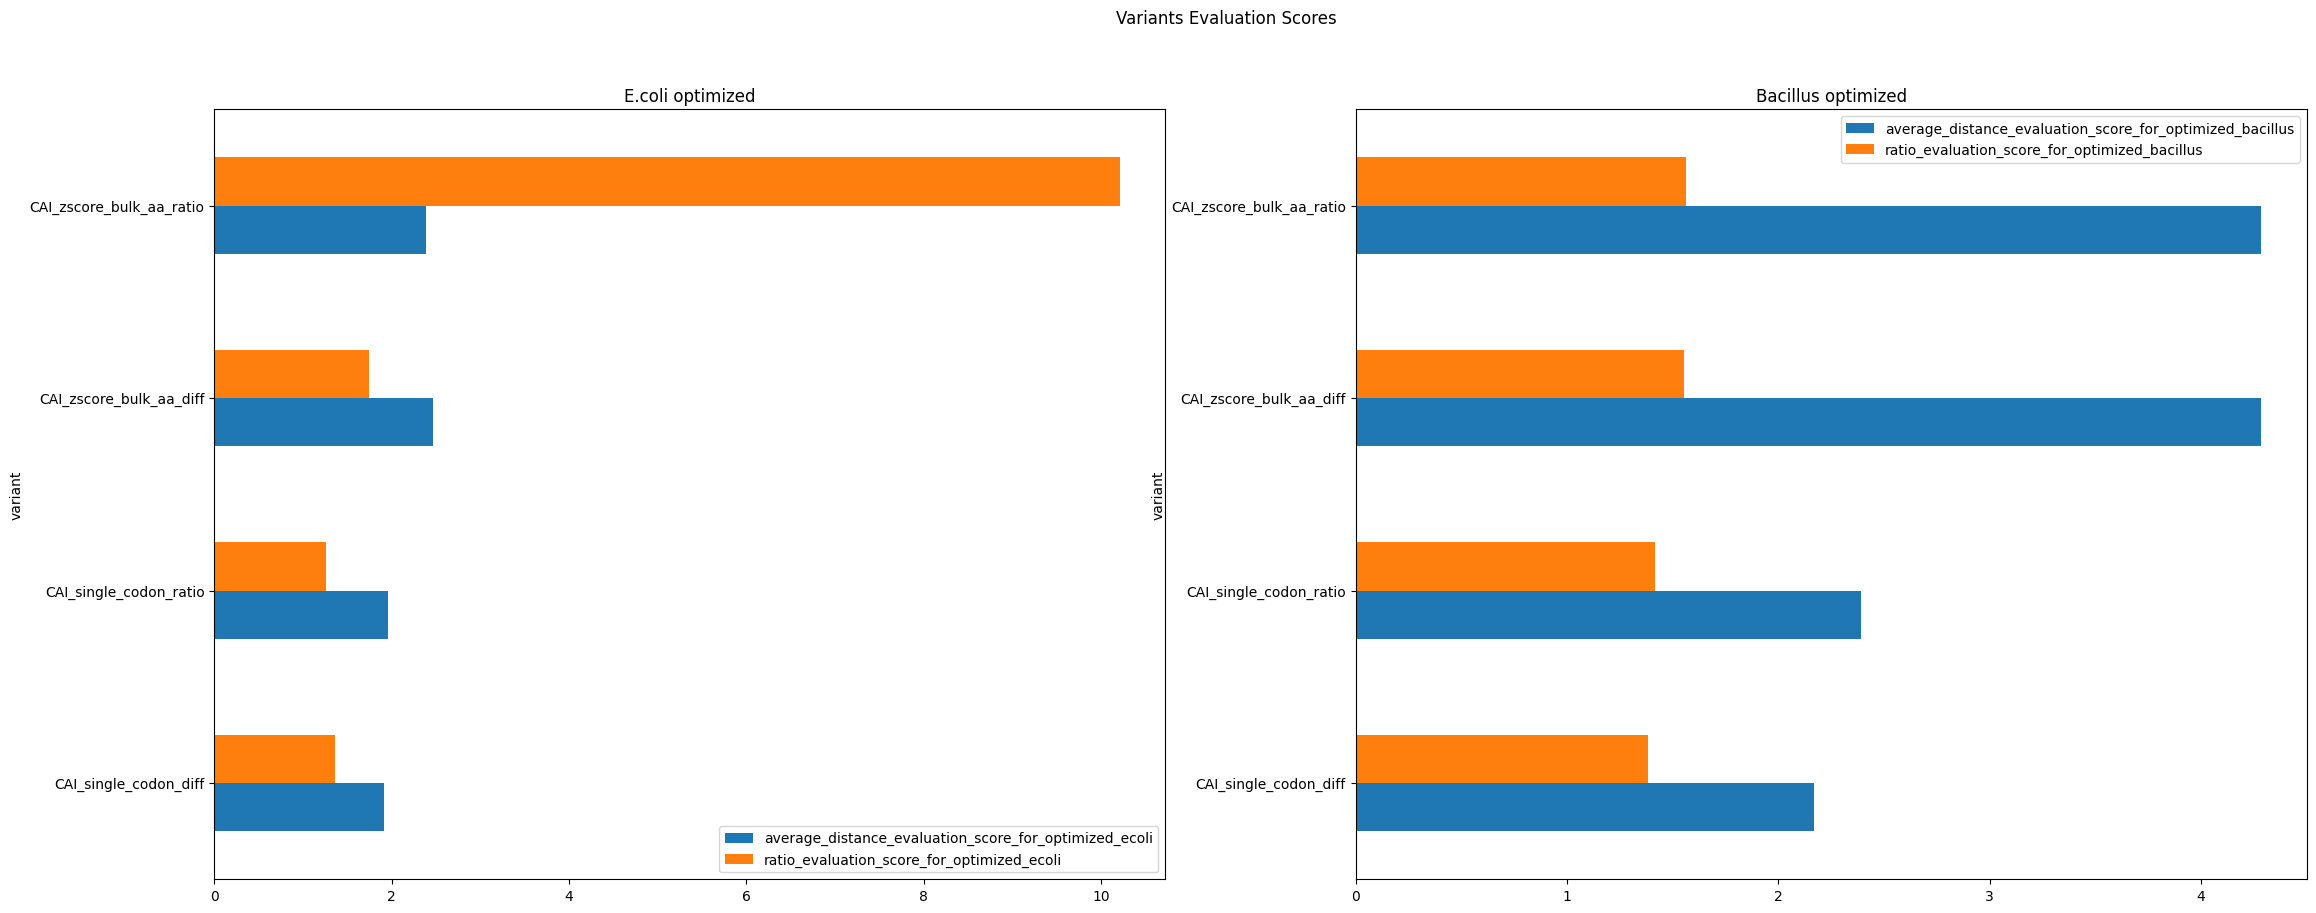

In [71]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(27,10))

fig.suptitle("Variants Evaluation Scores")
evaluation_ecoli_opt_variants_dataframe.plot("variant", kind="barh", ax=axes[0], title="E.coli optimized")
evaluation_bacillus_opt_variants_dataframe.plot("variant", kind="barh", ax=axes[1], title="Bacillus optimized")
# evaluation_ecoli_opt_variants_dataframe.plot("variant", kind="barh", ax=axes[0], title="E.coli optimized")
# evaluation_bacillus_opt_variants_dataframe.plot("variant", kind="barh", ax=axes[1], title="Bacillus optimized", color="#dc4d01")

## Comparing variant scores with random sequences

In [72]:
random_sequences_num = 1000
random_sequences = [shared_functions_and_vars.synonymous_codon_permutation(original_mcherry_seq) for _ in range(random_sequences_num)]

random_evaluation_scores = {}
dummy_optimization_method = "single_codon_ratio"
dummy_output_path = "results/mcherry_debug"
for optimization_cub_index in ["CAI", "tAI"]:
    for direction in [True, False]:
        user_input = get_user_input(
            optimization_method=dummy_optimization_method,
            optimization_cub_index=optimization_cub_index,
            is_ecoli_optimized=direction,
            orf_sequence=str(original_mcherry_seq),
            output_path=dummy_output_path,
            should_use_protein_abundance=True,
        )
        key = f"{optimization_cub_index}_ecoli_opt_{direction}"
        random_evaluation_scores[key] = []
        for random_sequence in random_sequences:
            evaluation_score = evaluate_score_for_sequence(
                sequence=random_sequence,
                user_input=user_input,
                optimization_method=dummy_optimization_method,
                optimization_cub_index=optimization_cub_index,
                is_ecoli_optimized=direction,
                orf_sequence=original_mcherry_seq,
                output_path=dummy_output_path,
            )
            random_evaluation_scores[key].append(evaluation_score)

##########################
# USER INPUT INFORMATION #
##########################
Open reading frame sequence for optimization is: ATGGTTTCCAAGGGCGAGGAGGATAACATGGCTATCATTAAAGAGTTCATGCGCTTCAAAGTTCACATGGAGGGTTCTGTTAACGGTCACGAGTTCGAGATCGAAGGCGAAGGCGAGGGCCGTCCGTATGAAGGCACCCAGACCGCCAAACTGAAAGTGACTAAAGGCGGCCCGCTGCCTTTTGCGTGGGACATCCTGAGCCCGCAATTTATGTACGGTTCTAAAGCGTATGTTAAACACCCAGCGGATATCCCGGACTATCTGAAGCTGTCTTTTCCGGAAGGTTTCAAGTGGGAACGCGTAATGAATTTTGAAGATGGTGGTGTCGTGACCGTCACTCAGGACTCCTCCCTGCAGGATGGCGAGTTCATCTATAAAGTTAAACTGCGTGGTACTAATTTTCCATCTGATGGCCCGGTGATGCAGAAAAAGACGATGGGTTGGGAGGCGTCTAGCGAACGCATGTATCCGGAAGATGGTGCGCTGAAAGGCGAAATTAAACAGCGCCTGAAACTGAAAGATGGCGGCCATTATGACGCTGAAGTGAAAACCACGTACAAAGCCAAGAAACCTGTGCAGCTGCCTGGCGCGTACAATGTGAATATTAAACTGGACATCACCTCTCATAATGAAGATTATACGATCGTAGAGCAATATGAGCGCGCGGAGGGTCGTCATTCTACCGGTGGCATGGATGAGCTGTACAAATAA
Organism is optimized
Information about Escherichia coli:
Extracting expression levels from: protein_abundance file.
Found 90 ribosomal proteins in input geno

KeyboardInterrupt: 

In [ ]:
def get_random_scores_df(is_ecoli_opt: bool):
    random_scores = defaultdict(dict)
    variants = evaluation_ecoli_opt_variants_dataframe["variant"]
    for key, values in random_evaluation_scores.items():
        if str(is_ecoli_opt) not in key:
            continue
        average_distance_scores = [x.average_distance_score for x  in values]
        average_distance_average = np.average(average_distance_scores)
        average_distance_std =  np.std(average_distance_scores)
        ratio_scores = [x.ratio_score for x  in values]
        ratio_average = np.average(ratio_scores)
        ratio_std =  np.std(ratio_scores)
        for variant in variants:
            if variant.startswith(key.split("_")[0]):
                random_scores[variant]["average_distance_average"] = average_distance_average
                random_scores[variant]["average_distance_std"] = average_distance_std
                random_scores[variant]["ratio_average"] = ratio_average
                random_scores[variant]["ratio_std"] = ratio_std
    
    random_scores_df_dict = {
        "variant": variants, 
        "random_average_distance_average": [random_scores[variant]["average_distance_average"] for variant in variants],
        "random_average_distance_std": [random_scores[variant]["average_distance_std"] for variant in variants],
        "random_ratio_average": [random_scores[variant]["ratio_average"] for variant in variants],
        "random_ratio_std": [random_scores[variant]["ratio_std"] for variant in variants],
    }

    return pd.DataFrame(random_scores_df_dict)   

ecoli_opt_random_scores_dataframe = get_random_scores_df(is_ecoli_opt=True)
new_evaluation_ecoli_opt_variants_dataframe = pd.merge(evaluation_ecoli_opt_variants_dataframe, ecoli_opt_random_scores_dataframe, on='variant', how='inner')
new_evaluation_ecoli_opt_variants_dataframe["average_distance_zscore"] = (new_evaluation_ecoli_opt_variants_dataframe["average_distance_evaluation_score_for_optimized_ecoli"] - new_evaluation_ecoli_opt_variants_dataframe["random_average_distance_average"]) / new_evaluation_ecoli_opt_variants_dataframe["random_average_distance_std"]
new_evaluation_ecoli_opt_variants_dataframe["ratio_zscore"] = (new_evaluation_ecoli_opt_variants_dataframe["ratio_evaluation_score_for_optimized_ecoli"] - new_evaluation_ecoli_opt_variants_dataframe["random_ratio_average"]) / new_evaluation_ecoli_opt_variants_dataframe["random_ratio_std"]


bacillus_opt_random_scores_dataframe = get_random_scores_df(is_ecoli_opt=False)
new_evaluation_bacillus_opt_variants_dataframe = pd.merge(evaluation_bacillus_opt_variants_dataframe, bacillus_opt_random_scores_dataframe, on='variant', how='inner')
new_evaluation_bacillus_opt_variants_dataframe["average_distance_zscore"] = (new_evaluation_bacillus_opt_variants_dataframe["average_distance_evaluation_score_for_optimized_bacillus"] - new_evaluation_bacillus_opt_variants_dataframe["random_average_distance_average"]) / new_evaluation_bacillus_opt_variants_dataframe["random_average_distance_std"]
new_evaluation_bacillus_opt_variants_dataframe["ratio_zscore"] = (new_evaluation_bacillus_opt_variants_dataframe["ratio_evaluation_score_for_optimized_bacillus"] - new_evaluation_bacillus_opt_variants_dataframe["random_ratio_average"]) / new_evaluation_bacillus_opt_variants_dataframe["random_ratio_std"]



In [ ]:
new_evaluation_ecoli_opt_variants_dataframe

In [ ]:
new_evaluation_bacillus_opt_variants_dataframe

In [ ]:
for key, values in random_evaluation_scores.items():
    variants = evaluation_ecoli_opt_variants_dataframe["variant"]
    for score_type in ["average_distance", "ratio"]:
        scores = [getattr(x, f"{score_type}_score") for x  in values]
        for variant in variants:
            if variant.startswith(key.split("_")[0]):
                for score in scores:
                    if "True" in key:
                        evaluation = evaluation_ecoli_opt_variants_dataframe[evaluation_ecoli_opt_variants_dataframe["variant"] == variant][f"{score_type}_evaluation_score_for_optimized_ecoli"]
                    else:
                        evaluation = evaluation_bacillus_opt_variants_dataframe[evaluation_bacillus_opt_variants_dataframe["variant"] == variant][f"{score_type}_evaluation_score_for_optimized_bacillus"]
                    evaluation = evaluation.reset_index(drop=True)
                    score_diff = evaluation - score
                    # print(score_diff)
                    if score_diff[0] <= 0 :
                        print(f"Found better random score: {score} for key: {key} and variant: {variant}")

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(30,10))

fig.suptitle("Variants Evaluation Z-Scores")
new_evaluation_ecoli_opt_variants_dataframe.plot("variant", "average_distance_zscore", kind="barh", ax=axes[0], title="E.coli optimized")
new_evaluation_bacillus_opt_variants_dataframe.plot("variant", "average_distance_zscore", kind="barh", ax=axes[1], title="Bacillus optimized", color="#dc4d01")

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(30,10))

fig.suptitle("Variants Evaluation Z-Scores")
new_evaluation_ecoli_opt_variants_dataframe.plot("variant", "ratio_zscore", kind="barh", ax=axes[0], title="E.coli optimized")
new_evaluation_bacillus_opt_variants_dataframe.plot("variant", "ratio_zscore", kind="barh", ax=axes[1], title="Bacillus optimized", color="#dc4d01")

In [ ]:
merged_df_ecoli = pd.merge(evaluation_ecoli_opt_variants_dataframe, ecoli_opt_variants_dataframe, on='variant', how='inner')
merged_df_ecoli['ecoli_freq_dist_diff'] =  merged_df_ecoli['ecoli_dist_for_optimized_ecoli'] - merged_df_ecoli['ecoli_dist_for_original_mcherry']
merged_df_ecoli['bacillus_freq_dist_diff'] = merged_df_ecoli['bacillus_dist_for_optimized_ecoli'] - merged_df_ecoli['bacillus_dist_for_original_mcherry']

merged_df_bacillus = pd.merge(evaluation_bacillus_opt_variants_dataframe, bacillus_opt_variants_dataframe, on='variant', how='inner')
merged_df_bacillus['ecoli_freq_dist_diff'] =  merged_df_bacillus['ecoli_dist_for_optimized_bacillus'] - merged_df_bacillus['ecoli_dist_for_original_mcherry']
merged_df_bacillus['bacillus_freq_dist_diff'] = merged_df_bacillus['bacillus_dist_for_optimized_bacillus'] - merged_df_bacillus['bacillus_dist_for_original_mcherry'] 


fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,15))
fig.suptitle("Ecaluation Score vs. Codon Frequencies distance")

scatter = merged_df_ecoli.plot.scatter(x="average_distance_evaluation_score_for_optimized_ecoli", y="ecoli_freq_dist_diff", ax=axes[0,0], title="E.coli optimized - Evaluation score vs.\nE.coli codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.spearmanr(merged_df_ecoli["average_distance_evaluation_score_for_optimized_ecoli"], merged_df_ecoli["ecoli_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_ecoli.plot.scatter(x="average_distance_evaluation_score_for_optimized_ecoli", y="bacillus_freq_dist_diff", ax=axes[0,1], title="E.coli optimized - Evaluation score vs.\nBacillus codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.spearmanr(merged_df_ecoli["average_distance_evaluation_score_for_optimized_ecoli"], merged_df_ecoli["bacillus_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus.plot.scatter(x="average_distance_evaluation_score_for_optimized_bacillus", y="ecoli_freq_dist_diff", ax=axes[1,0], title="Bacillus optimized - Evaluation score vs.\nE.coli codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.spearmanr(merged_df_bacillus["average_distance_evaluation_score_for_optimized_bacillus"], merged_df_bacillus["ecoli_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus.plot.scatter(x="average_distance_evaluation_score_for_optimized_bacillus", y="bacillus_freq_dist_diff", ax=axes[1,1], title="Bacillus optimized - Evaluation score vs.\nBacillus codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.spearmanr(merged_df_bacillus["average_distance_evaluation_score_for_optimized_bacillus"], merged_df_bacillus["bacillus_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

In [ ]:
merged_df_ecoli = pd.merge(evaluation_ecoli_opt_greater_alpha_variants_dataframe, greater_alpha_ecoli_opt_variants_dataframe, on='variant', how='inner')
merged_df_ecoli['ecoli_freq_dist_diff'] =  merged_df_ecoli['ecoli_dist_for_optimized_ecoli'] - merged_df_ecoli['ecoli_dist_for_original_mcherry']
merged_df_ecoli['bacillus_freq_dist_diff'] = merged_df_ecoli['bacillus_dist_for_optimized_ecoli'] - merged_df_ecoli['bacillus_dist_for_original_mcherry']

merged_df_bacillus = pd.merge(evaluation_bacillus_opt_greater_alpha_variants_dataframe, greater_alpha_bacillus_opt_variants_dataframe, on='variant', how='inner')
merged_df_bacillus['ecoli_freq_dist_diff'] =  merged_df_bacillus['ecoli_dist_for_optimized_bacillus'] - merged_df_bacillus['ecoli_dist_for_original_mcherry']
merged_df_bacillus['bacillus_freq_dist_diff'] = merged_df_bacillus['bacillus_dist_for_optimized_bacillus'] - merged_df_bacillus['bacillus_dist_for_original_mcherry'] 


fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,13))
fig.suptitle("Ecaluation Score vs. Codon Frequencies distance (alpha=1)")

scatter = merged_df_ecoli.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="ecoli_freq_dist_diff", ax=axes[0,0], title="E.coli optimized - Evaluation score vs.\nE.coli codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_ecoli["evaluation_score_for_optimized_ecoli"], merged_df_ecoli["ecoli_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_ecoli.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="bacillus_freq_dist_diff", ax=axes[0,1], title="E.coli optimized - Evaluation score vs.\nBacillus codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_ecoli["evaluation_score_for_optimized_ecoli"], merged_df_ecoli["bacillus_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="ecoli_freq_dist_diff", ax=axes[1,0], title="Bacillus optimized - Evaluation score vs.\nE.coli codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_bacillus["evaluation_score_for_optimized_bacillus"], merged_df_bacillus["ecoli_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="bacillus_freq_dist_diff", ax=axes[1,1], title="Bacillus optimized - Evaluation score vs.\nBacillus codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_bacillus["evaluation_score_for_optimized_bacillus"], merged_df_bacillus["bacillus_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

In [ ]:
merged_df_ecoli = pd.merge(evaluation_ecoli_opt_lower_alpha_variants_dataframe, lower_alpha_ecoli_opt_variants_dataframe, on='variant', how='inner')
merged_df_ecoli['ecoli_freq_dist_diff'] =  merged_df_ecoli['ecoli_dist_for_optimized_ecoli'] - merged_df_ecoli['ecoli_dist_for_original_mcherry']
merged_df_ecoli['bacillus_freq_dist_diff'] = merged_df_ecoli['bacillus_dist_for_optimized_ecoli'] - merged_df_ecoli['bacillus_dist_for_original_mcherry']

merged_df_bacillus = pd.merge(evaluation_bacillus_opt_lower_alpha_variants_dataframe, lower_alpha_bacillus_opt_variants_dataframe, on='variant', how='inner')
merged_df_bacillus['ecoli_freq_dist_diff'] =  merged_df_bacillus['ecoli_dist_for_optimized_bacillus'] - merged_df_bacillus['ecoli_dist_for_original_mcherry']
merged_df_bacillus['bacillus_freq_dist_diff'] = merged_df_bacillus['bacillus_dist_for_optimized_bacillus'] - merged_df_bacillus['bacillus_dist_for_original_mcherry'] 


fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,13))
fig.suptitle("Ecaluation Score vs. Codon Frequencies distance (alpha=0)")

scatter = merged_df_ecoli.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="ecoli_freq_dist_diff", ax=axes[0,0], title="Bacillus deoptimized - Evaluation score vs.\nE.coli codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_ecoli["evaluation_score_for_optimized_ecoli"], merged_df_ecoli["ecoli_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_ecoli.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="bacillus_freq_dist_diff", ax=axes[0,1], title="Bacillus deoptimized - Evaluation score vs.\nBacillus codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_ecoli["evaluation_score_for_optimized_ecoli"], merged_df_ecoli["bacillus_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="ecoli_freq_dist_diff", ax=axes[1,0], title="E.coli deoptimized - Evaluation score vs.\nE.coli codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_bacillus["evaluation_score_for_optimized_bacillus"], merged_df_bacillus["ecoli_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="bacillus_freq_dist_diff", ax=axes[1,1], title="E.coli deoptimized - Evaluation score vs.\nBacillus codon frequencies diff (modified seq dist-original seq dist)")
r, p = stats.pearsonr(merged_df_bacillus["evaluation_score_for_optimized_bacillus"], merged_df_bacillus["bacillus_freq_dist_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

In [ ]:
merged_df_ecoli = pd.merge(evaluation_ecoli_opt_variants_dataframe, cub_ecoli_opt_variants_dataframe, on='variant', how='inner')
merged_df_ecoli['ecoli_score_diff'] = merged_df_ecoli['ecoli_final_score'] - merged_df_ecoli['ecoli_initial_score']
merged_df_ecoli['bacillus_score_diff'] = merged_df_ecoli['bacillus_final_score'] - merged_df_ecoli['bacillus_initial_score']

merged_df_bacillus = pd.merge(evaluation_bacillus_opt_variants_dataframe, cub_bacillus_opt_variants_dataframe, on='variant', how='inner')
merged_df_bacillus['ecoli_score_diff'] = merged_df_bacillus['ecoli_final_score'] - merged_df_bacillus['ecoli_initial_score']
merged_df_bacillus['bacillus_score_diff'] = merged_df_bacillus['bacillus_final_score'] - merged_df_bacillus['bacillus_initial_score']

fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,15))

scatter = merged_df_ecoli.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="ecoli_score_diff", ax=axes[0,0], title="E.coli optimized - Evaluation score vs.\nE.coli CUB score diff (modified seq score-original seq score)")
r, p = stats.spearmanr(merged_df_ecoli["evaluation_score_for_optimized_ecoli"], merged_df_ecoli["ecoli_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_ecoli.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="bacillus_score_diff", ax=axes[0,1], title="E.coli optimized - Evaluation score vs.\nBacillus CUB score diff (modified seq score-original seq score)")
r, p = stats.spearmanr(merged_df_ecoli["evaluation_score_for_optimized_ecoli"], merged_df_ecoli["bacillus_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="ecoli_score_diff", ax=axes[1,0], title="Bacillus optimized - Evaluation score vs.\nE.coli CUB score diff (modified seq score-original seq score)")
r, p = stats.spearmanr(merged_df_bacillus["evaluation_score_for_optimized_bacillus"], merged_df_bacillus["ecoli_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="bacillus_score_diff", ax=axes[1,1], title="Bacillus optimized - Evaluation score vs.\nBacillus CUB score diff (modified seq score-original seq score)")
r, p = stats.spearmanr(merged_df_bacillus["evaluation_score_for_optimized_bacillus"], merged_df_bacillus["bacillus_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

In [ ]:
merged_df_ecoli_greater_alpha = pd.merge(evaluation_ecoli_opt_greater_alpha_variants_dataframe, cub_ecoli_opt_greater_alpha_variants_dataframe, on='variant', how='inner')
merged_df_ecoli_greater_alpha['ecoli_score_diff'] = merged_df_ecoli_greater_alpha['ecoli_final_score'] - merged_df_ecoli_greater_alpha['ecoli_initial_score']
merged_df_ecoli_greater_alpha['bacillus_score_diff'] = merged_df_ecoli_greater_alpha['bacillus_final_score'] - merged_df_ecoli_greater_alpha['bacillus_initial_score']

merged_df_bacillus_greater_alpha = pd.merge(evaluation_bacillus_opt_greater_alpha_variants_dataframe, cub_bacillus_opt_greater_alpha_variants_dataframe, on='variant', how='inner')
merged_df_bacillus_greater_alpha['ecoli_score_diff'] = merged_df_bacillus_greater_alpha['ecoli_final_score'] - merged_df_bacillus_greater_alpha['ecoli_initial_score']
merged_df_bacillus_greater_alpha['bacillus_score_diff'] = merged_df_bacillus_greater_alpha['bacillus_final_score'] - merged_df_bacillus_greater_alpha['bacillus_initial_score']

fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,15))

scatter = merged_df_ecoli_greater_alpha.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="ecoli_score_diff", ax=axes[0,0], title="E.coli optimized (alpha=1)- Evaluation score vs.\nE.coli CUB score diff (modified seq score-original seq score")
r, p = stats.spearmanr(merged_df_ecoli_greater_alpha["evaluation_score_for_optimized_ecoli"], merged_df_ecoli_greater_alpha["ecoli_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_ecoli_greater_alpha.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="bacillus_score_diff", ax=axes[0,1], title="E.coli optimized (alpha=1)- Evaluation score vs.\nBacillus CUB score diff (modified seq score-original seq score")
r, p = stats.spearmanr(merged_df_ecoli_greater_alpha["evaluation_score_for_optimized_ecoli"], merged_df_ecoli_greater_alpha["bacillus_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus_greater_alpha.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="ecoli_score_diff", ax=axes[1,0], title="Bacillus optimized (alpha=1)- Evaluation score vs.\nE.coli CUB score diff (modified seq score-original seq score")
r, p = stats.spearmanr(merged_df_bacillus_greater_alpha["evaluation_score_for_optimized_bacillus"], merged_df_bacillus_greater_alpha["ecoli_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus_greater_alpha.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="bacillus_score_diff", ax=axes[1,1], title="Bacillus optimized (alpha=1)- Evaluation score vs.\nBacillus CUB score diff (modified seq score-original seq score")
r, p = stats.spearmanr(merged_df_bacillus_greater_alpha["evaluation_score_for_optimized_bacillus"], merged_df_bacillus_greater_alpha["bacillus_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

In [ ]:
merged_df_ecoli_lower_alpha = pd.merge(evaluation_ecoli_opt_lower_alpha_variants_dataframe, cub_ecoli_opt_lower_alpha_variants_dataframe, on='variant', how='inner')
merged_df_ecoli_lower_alpha['ecoli_score_diff'] = merged_df_ecoli_lower_alpha['ecoli_final_score'] - merged_df_ecoli_lower_alpha['ecoli_initial_score']
merged_df_ecoli_lower_alpha['bacillus_score_diff'] = merged_df_ecoli_lower_alpha['bacillus_final_score'] - merged_df_ecoli_lower_alpha['bacillus_initial_score']

merged_df_bacillus_lower_alpha = pd.merge(evaluation_bacillus_opt_lower_alpha_variants_dataframe, cub_bacillus_opt_lower_alpha_variants_dataframe, on='variant', how='inner')
merged_df_bacillus_lower_alpha['ecoli_score_diff'] = merged_df_bacillus_lower_alpha['ecoli_final_score'] - merged_df_bacillus_lower_alpha['ecoli_initial_score']
merged_df_bacillus_lower_alpha['bacillus_score_diff'] = merged_df_bacillus_lower_alpha['bacillus_final_score'] - merged_df_bacillus_lower_alpha['bacillus_initial_score']

fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,15))

scatter = merged_df_ecoli_lower_alpha.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="ecoli_score_diff", ax=axes[0,0], title="Bacillus deoptimized (alpha=0)- Evaluation score vs.\nE.coli CUB score diff (modified seq score-original seq score")
r, p = stats.spearmanr(merged_df_ecoli_lower_alpha["evaluation_score_for_optimized_ecoli"], merged_df_ecoli_lower_alpha["ecoli_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_ecoli_lower_alpha.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="bacillus_score_diff", ax=axes[0,1], title="Bacillus deoptimized (alpha=0)- Evaluation score vs.\nBacillus CUB score diff (modified seq score-original seq score")
r, p = stats.spearmanr(merged_df_ecoli_lower_alpha["evaluation_score_for_optimized_ecoli"], merged_df_ecoli_lower_alpha["bacillus_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus_lower_alpha.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="ecoli_score_diff", ax=axes[1,0], title="E.coli deoptimized (alpha=0)- Evaluation score vs.\nE.coli CUB score diff (modified seq score-original seq score")
r, p = stats.spearmanr(merged_df_bacillus_lower_alpha["evaluation_score_for_optimized_bacillus"], merged_df_bacillus_lower_alpha["ecoli_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

scatter = merged_df_bacillus_lower_alpha.plot.scatter(x="evaluation_score_for_optimized_bacillus", y="bacillus_score_diff", ax=axes[1,1], title="E.coli deoptimized (alpha=0)- Evaluation score vs.\nBacillus CUB score diff (modified seq score-original seq score")
r, p = stats.spearmanr(merged_df_bacillus_lower_alpha["evaluation_score_for_optimized_bacillus"], merged_df_bacillus_lower_alpha["bacillus_score_diff"])
scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')

In [ ]:
my_colors = ['#3b5b92', '#3b5b92', '#dc4d01', '#dc4d01'] 
my_colors_extended = ['cornflowerblue', 'cornflowerblue', 'navy', 'navy', 'orange', 'orange', 'orangered', 'orangered'] 
for q in range(cub_ecoli_opt_greater_alpha_variants_dataframe.shape[0]):

    fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,5))
    fig.suptitle(greater_alpha_ecoli_opt_variants_dataframe.iloc[q,0] + " - codon frequency distance")
    lower_alpha_ecoli_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[0], stacked=True, color=my_colors_extended)
    axes[0].set_title("alpha = 0")
    ecoli_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[1], stacked=True, color=my_colors_extended)
    axes[1].set_title("alpha = 0.5")
    greater_alpha_ecoli_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[2], stacked=True, color=my_colors_extended)
    axes[2].set_title("alpha = 1")
    
    fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,5))
    fig.suptitle(greater_alpha_ecoli_opt_variants_dataframe_highly_expressed.iloc[q,0] + " - codon frequency distance (highly expressed)")
    lower_alpha_ecoli_opt_variants_dataframe_highly_expressed.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[0], stacked=True, color=my_colors_extended)
    axes[0].set_title("alpha = 0")
    ecoli_opt_variants_dataframe_highly_expressed.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[1], stacked=True, color=my_colors_extended)
    axes[1].set_title("alpha = 0.5")
    greater_alpha_ecoli_opt_variants_dataframe_highly_expressed.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[2], stacked=True, color=my_colors_extended)
    axes[2].set_title("alpha = 1")


    fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,5))
    fig.suptitle(cub_ecoli_opt_greater_alpha_variants_dataframe.iloc[q,0] + " - CUB scores")
    cub_ecoli_opt_lower_alpha_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[0], stacked=True, color=my_colors)
    axes[0].set_title("alpha = 0")
    cub_ecoli_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[1], stacked=True, color=my_colors)
    axes[1].set_title("alpha = 0.5")
    cub_ecoli_opt_greater_alpha_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[2], stacked=True, color=my_colors)
    axes[2].set_title("alpha = 1")

## Optimizing for Bacillus

In [ ]:
my_colors = ['#3b5b92', '#3b5b92', '#dc4d01', '#dc4d01'] 
my_colors_extended = ['cornflowerblue', 'cornflowerblue', 'navy', 'navy', 'orange', 'orange', 'orangered', 'orangered'] 
for q in range(cub_bacillus_opt_greater_alpha_variants_dataframe.shape[0]):

    fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,5))
    fig.suptitle(greater_alpha_bacillus_opt_variants_dataframe.iloc[q,0] + " - codon frequency distance")
    lower_alpha_bacillus_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[0], stacked=True, color=my_colors_extended)
    axes[0].set_title("alpha = 0")
    bacillus_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[1], stacked=True, color=my_colors_extended)
    axes[1].set_title("alpha = 0.5")
    greater_alpha_bacillus_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[2], stacked=True, color=my_colors_extended)
    axes[2].set_title("alpha = 1")
    
    fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,5))
    fig.suptitle(greater_alpha_bacillus_opt_variants_dataframe_highly_expressed.iloc[q,0] + " - codon frequency distance (highly expressed)")
    lower_alpha_bacillus_opt_variants_dataframe_highly_expressed.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[0], stacked=True, color=my_colors_extended)
    axes[0].set_title("alpha = 0")
    bacillus_opt_variants_dataframe_highly_expressed.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[1], stacked=True, color=my_colors_extended)
    axes[1].set_title("alpha = 0.5")
    greater_alpha_bacillus_opt_variants_dataframe_highly_expressed.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[2], stacked=True, color=my_colors_extended)
    axes[2].set_title("alpha = 1")


    fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,5))
    fig.suptitle(cub_bacillus_opt_greater_alpha_variants_dataframe.iloc[q,0] + " - CUB scores")
    cub_bacillus_opt_lower_alpha_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[0], stacked=True, color=my_colors)
    axes[0].set_title("alpha = 0")
    cub_bacillus_opt_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[1], stacked=True, color=my_colors)
    axes[1].set_title("alpha = 0.5")
    cub_bacillus_opt_greater_alpha_variants_dataframe.iloc[q,1:].plot(x="variant", kind="bar", ax=axes[2], stacked=True, color=my_colors)
    axes[2].set_title("alpha = 1")

## Debugging negative non normalized score

In [ ]:
root_dir = r"C:\projects\Igem_TAU_2021_moran\analysis\orf_model_analysis\results\endogenous-remote-debug\CAI_single_codon_diff_ecoli_opt_False_DppD"
run_summary_path = os.path.join(root_dir, "run_summary.json")

with open(run_summary_path, "r") as json_file:
    run_summary = json.load(json_file)

stats_dict = defaultdict(list)
for codon in run_summary["orf_sequence_stats"].keys():
    stats_dict["codon"].append(codon)
    stats_dict["aa"].append(shared_functions_and_vars.nt_to_aa[codon])
    stats_dict["counts"].append(run_summary["orf_sequence_stats"][codon])
    stats_dict["optimized_loss"].append(run_summary["orf_debug"]["optimized_loss"][shared_functions_and_vars.nt_to_aa[codon]][codon])
    stats_dict["deoptimized_loss"].append(run_summary["orf_debug"]["deoptimized_loss"][shared_functions_and_vars.nt_to_aa[codon]][codon])
    stats_dict["total_loss"].append(run_summary["orf_debug"]["total_loss"][shared_functions_and_vars.nt_to_aa[codon]][codon])
    stats_dict["optimal"].append(run_summary["orf"]["aa_to_optimal_codon"][shared_functions_and_vars.nt_to_aa[codon]] == codon)

stats_df = pd.DataFrame(stats_dict)
total = stats_df.groupby(stats_df["aa"]).aggregate({"counts": "sum"})

filtered_df = stats_df[stats_df.optimal]
merged = filtered_df.merge(total, on='aa', how='inner', suffixes=("", "_aa") )
merged

In [ ]:
# scatter = merged_df_ecoli_lower_alpha.plot.scatter(x="evaluation_score_for_optimized_ecoli", y="ecoli_score_diff", ax=axes[0,0], title="Bacillus deoptimized (alpha=0)- Evaluation score vs.\nE.coli CUB score diff (modified seq score-original seq score")
# TODO - think how to visualize the data in order to show the trend
# stats_df.plot()

colors = ['r', 'b', 'k', 'g', 'm']
merged.plot.scatter(x="optimized_loss", y="deoptimized_loss", s=10*merged.counts_aa)
stats_df.plot.scatter(x="optimized_loss", y="deoptimized_loss", s=10*stats_df.counts)